# Training CPCE network with the dataset

* ## Wasserstein GAN + Gradient Penalty + Perceptual loss

In [1]:
import tensorflow as tf
import numpy as np
import h5py
# import pydicom as dicom
import scipy.io as sio
import scipy.misc
import time
import datetime
import os
import logging
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os

## Step 1: Specific GPU

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

## Step 2: Customize hyperparameter

In [3]:
# The size of the input and output
input_width = 64
input_height = 64

output_width = 64
output_height = 64

batch_size = 32*4

learning_rate = 1e-4

num_epoch = 20
disc_iters = 4 
Eperiod = 8

# beta1 and beta2 for adam optimization metod
beta1 = 0.9
beta2 = 0.999

train_version = 0
###################################################
Methodname='CPCE_SR'
lambda_p = 0.1
Networkfolder = './Networks/'+Methodname+'_lambda_p_'+str(lambda_p)+'/trainV'+str(train_version)
timestr = time.strftime("%Y%m%d-%H%M%S")
logfilename = Networkfolder + '/CPCE_SR'+timestr+'.log'
###################################################

try:
    os.makedirs(Networkfolder)
except OSError:
    print ("Creation of the directory %s failed" % Networkfolder)
else:
    print ("Successfully created the directory %s" % Networkfolder)
# # path check
# if os.path.exists( + Networkfolder):
#     print ('Networks/' + Networkfolder + ' exists!!!!!')
#     #raise NameError('Folder exists')
# if os.path.exists(logfilename):
#     print ('Log File has existed!!!!')
#     #raise NameError('Log FIle exists!!!')
    

Creation of the directory ./Networks/CPCE_SR_lambda_p_0.1/trainV0 failed


## Step 3: Write down all the logs with logging...

In [4]:

# Logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s, %(message)s',
                    filename=logfilename,
                    filemode='w')

logging.info('Epoch, batch, time, disc_loss, Wass_D, vgg_cost, mse_cost, gen_loss, gen_cost, is_training')

## Step 4: Define the structure of generator and discriminator.

In [ ]:
# Generator
def CPCE(inputs, padding='valid'):
    #inputs = tf.placeholder(dtype=tf.float32, shape=[None, input_width, input_height, 1])
    outputs1 = tf.layers.conv2d(inputs, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv1', use_bias=False)
    outputs2 = tf.nn.relu(outputs1)
    
    outputs2 = tf.layers.conv2d(outputs2, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv2', use_bias=False)
    outputs3 = tf.nn.relu(outputs2)
    
    outputs3 = tf.layers.conv2d(outputs3, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv3', use_bias=False)
    outputs4 = tf.nn.relu(outputs3)
    
    outputs4 = tf.layers.conv2d(outputs4, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv4', use_bias=False)
    outputs5 = tf.nn.relu(outputs4)
    
    outputs5 = tf.layers.conv2d_transpose(outputs5, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='deconv5', use_bias=False)
    outputs5 = tf.concat([outputs3, outputs5], 3)
    outputs5 = tf.nn.relu(outputs5)
    
    outputs5 = tf.layers.conv2d(outputs5, 32, 1, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='transpose1', use_bias=False)
    outputs6 = tf.nn.relu(outputs5)

    outputs6 = tf.layers.conv2d_transpose(outputs6, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='deconv6', use_bias=False)
    outputs6 = tf.concat([outputs2, outputs6], 3)
    outputs6 = tf.nn.relu(outputs6)
    
    outputs6 = tf.layers.conv2d(outputs6, 32, 1, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='transpose2', use_bias=False)
    outputs7 = tf.nn.relu(outputs6)

    outputs7 = tf.layers.conv2d_transpose(outputs7, 32, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='deconv7', use_bias=False)
    outputs7 = tf.concat([outputs1, outputs7], 3)
    outputs7 = tf.nn.relu(outputs7)
    
    outputs7= tf.layers.conv2d(outputs7, 32, 1, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='transpose3', use_bias=False)
    outputs8 = tf.nn.relu(outputs7)

    outputs8 = tf.layers.conv2d_transpose(outputs8, 1, 3, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='deconv8', use_bias=False)
#     outputs = tf.nn.relu(outputs8 + inputs)
    outputs = outputs8 + inputs
    
    return outputs

# leaky_relu
def leaky_relu(inputs, alpha):
    return 0.5 * (1 + alpha) * inputs + 0.5 * (1-alpha) * tf.abs(inputs)

# discriminator
def discriminator_model(inputs):
    outputs = tf.layers.conv2d(inputs, 64, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv1')
    outputs = leaky_relu(outputs, alpha=0.2)

    outputs = tf.layers.conv2d(outputs, 64, 3, padding='same', strides=(2,2), kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv2')
    outputs = leaky_relu(outputs, alpha=0.2)

    outputs = tf.layers.conv2d(outputs, 128, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv3')
    outputs = leaky_relu(outputs, alpha=0.2)

    outputs = tf.layers.conv2d(outputs, 128, 3, padding='same', strides=(2,2), kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv4')
    outputs = leaky_relu(outputs, alpha=0.2)

    outputs = tf.layers.conv2d(outputs, 256, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv5')
    outputs = leaky_relu(outputs, alpha=0.2)

    outputs = tf.layers.conv2d(outputs, 256, 3, padding='same', strides=(2,2), kernel_initializer=tf.contrib.layers.xavier_initializer(), name='conv6')
    outputs = leaky_relu(outputs, alpha=0.2)

    #outputs = tf.contrib.layers.flatten(outputs)
    outputs = tf.layers.dense(outputs, units=1024, name='dense1')
    outputs = leaky_relu(outputs, alpha=0.2)
    outputs = tf.layers.dense(outputs, units=1, name='dense2')

    return outputs

## Step 5: Load VGG model

In [ ]:

def vgg_model(inputs):
    #outputs = tf.tile(inputs, (1,1,1,3)) * 255
    #img_mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
    #outputs = outputs - img_mean
    outputs = tf.concat([inputs*255-103.939, inputs*255-116.779, inputs*255-123.68], 3)
    outputs = tf.layers.conv2d(outputs, 64, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv1_1')
    outputs = tf.layers.conv2d(outputs, 64, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv1_2')
    outputs = tf.layers.max_pooling2d(outputs, 2, strides=(2,2), padding='same', name='pool1')

    outputs = tf.layers.conv2d(outputs, 128, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv2_1')
    outputs = tf.layers.conv2d(outputs, 128, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv2_2')
    outputs = tf.layers.max_pooling2d(outputs, 2, strides=(2,2), padding='same', name='pool2')

    outputs = tf.layers.conv2d(outputs, 256, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv3_1')
    outputs = tf.layers.conv2d(outputs, 256, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv3_2')
    outputs = tf.layers.conv2d(outputs, 256, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv3_3')
    outputs = tf.layers.conv2d(outputs, 256, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv3_4')
    outputs = tf.layers.max_pooling2d(outputs, 2, strides=(2,2), padding='same', name='pool3')

    outputs = tf.layers.conv2d(outputs, 512, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv4_1')
    outputs = tf.layers.conv2d(outputs, 512, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv4_2')
    outputs = tf.layers.conv2d(outputs, 512, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv4_3')
    outputs = tf.layers.conv2d(outputs, 512, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv4_4')
    outputs = tf.layers.max_pooling2d(outputs, 2, strides=(2,2), padding='same', name='pool4')

    outputs = tf.layers.conv2d(outputs, 512, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv5_1')
    outputs = tf.layers.conv2d(outputs, 512, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv5_2')
    outputs = tf.layers.conv2d(outputs, 512, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv5_3')
    outputs = tf.layers.conv2d(outputs, 512, 3, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), activation=tf.nn.relu, name='conv5_4')
    print(outputs.shape)
    return outputs

## Step 6: Import generator and discriminator

In [ ]:
# generator networks

# input size
X = tf.placeholder(dtype=tf.float32, shape=[None, input_width, input_height, 1])
with tf.variable_scope('generator_model') as scope:
    # Y is the output of network
    Y = CPCE(X, padding='valid') 
    
# ground truth
real_label = tf.placeholder(dtype=tf.float32, shape=[None, output_width, output_height, 1])

alpha = tf.random_uniform(shape=[batch_size,1], minval=0.,maxval=1.)

# discriminator networks
with tf.variable_scope('discriminator_model') as scope:
    disc_real = discriminator_model(real_label)
    scope.reuse_variables()
    disc_fake = discriminator_model(Y)
    interpolates = alpha*tf.reshape(real_label, [batch_size, -1]) + (1-alpha)*tf.reshape(Y, [batch_size, -1])
    interpolates = tf.reshape(interpolates, [batch_size, output_width, output_height, 1])
    gradients = tf.gradients(discriminator_model(interpolates), [interpolates])[0]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.dense instead.


## Step 7: Different loss function / metrics

In [ ]:
# generator cost
gen_cost = -tf.reduce_mean(disc_fake) 

# Wasserstein distance   
Wass_D = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

# gradient penalty
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)

# Final disc objective function
disc_loss = Wass_D + 10 * gradient_penalty   # add gradient constraint to discriminator loss



# vgg network

with tf.variable_scope('vgg16') as scope:
    vgg_real = vgg_model(real_label)
    scope.reuse_variables()
    vgg_fake = vgg_model(Y)


mse_cost = tf.reduce_mean(tf.squared_difference(Y, real_label))
vgg_cost = tf.reduce_mean(tf.squared_difference(vgg_real, vgg_fake)) 

# final generator loss
gen_loss = gen_cost +   lambda_p * vgg_cost

Instructions for updating:
Use keras.layers.max_pooling2d instead.
(?, 4, 4, 512)
(?, 4, 4, 512)


## Step 8: Choose optimization method

In [ ]:
# optimizer

vgg_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='vgg16')
gen_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator_model')
disc_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator_model')

lr = tf.placeholder(tf.float32, shape=[])
gen_train_op = tf.train.AdamOptimizer(learning_rate=lr, 
                                        beta1=beta1,
                                        beta2=beta2
                                    ).minimize(gen_loss, var_list=gen_params)

disc_train_op = tf.train.AdamOptimizer(learning_rate=lr, 
                                        beta1=beta1,
                                        beta2=beta2
                                    ).minimize(disc_loss, var_list=disc_params)

Instructions for updating:
Use tf.cast instead.


## Step 9: Lunch session and load VGG parameters

In [ ]:
# training
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())

# load vgg weights
print ("Initialize VGG network ... ")
weights = np.load('vgg19.npy', encoding='latin1').item()
keys = sorted(weights.keys())
layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2',
        'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4',
        'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4',
        'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4']

for i, k in enumerate(layers):
    print (i, k, weights[k][0].shape, weights[k][1].shape)
    sess.run(vgg_params[2*i].assign(weights[k][0]))
    sess.run(vgg_params[2*i+1].assign(weights[k][1]))

# model save
saver = tf.train.Saver(max_to_keep = 3)

Initialize VGG network ... 
0 conv1_1 (3, 3, 3, 64) (64,)
1 conv1_2 (3, 3, 64, 64) (64,)
2 conv2_1 (3, 3, 64, 128) (128,)
3 conv2_2 (3, 3, 128, 128) (128,)
4 conv3_1 (3, 3, 128, 256) (256,)
5 conv3_2 (3, 3, 256, 256) (256,)
6 conv3_3 (3, 3, 256, 256) (256,)
7 conv3_4 (3, 3, 256, 256) (256,)
8 conv4_1 (3, 3, 256, 512) (512,)
9 conv4_2 (3, 3, 512, 512) (512,)
10 conv4_3 (3, 3, 512, 512) (512,)
11 conv4_4 (3, 3, 512, 512) (512,)
12 conv5_1 (3, 3, 512, 512) (512,)
13 conv5_2 (3, 3, 512, 512) (512,)
14 conv5_3 (3, 3, 512, 512) (512,)
15 conv5_4 (3, 3, 512, 512) (512,)


## Step 10: patches normalization, different CT windowing

In [ ]:
def normalization(x, lower = -300.0, upper = 300.0):
    
    # -1024 is the HU correction
#     x = (x - 1024.0 - lower) / (upper - lower)
    x[x<0.0] = 0.0
    x[x>1.0] = 1.0
    return x

Start training ... 


D:\Users\edwar\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
D:\Users\edwar\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Epoch: 1-0/10 - 27(0.02) - disc_loss: 0.15282 - gen_loss: 1.97084 - vgg_loss: 18.15766  - mse_loss: 0.001589092
Epoch: 1-0/10 - 55(0.04) - disc_loss: -0.12380 - gen_loss: 1.92283 - vgg_loss: 16.53874  - mse_loss: 0.001512834
Epoch: 1-0/10 - 83(0.06) - disc_loss: -0.10016 - gen_loss: 1.32933 - vgg_loss: 11.05451  - mse_loss: 0.001011841
Epoch: 1-0/10 - 111(0.08) - disc_loss: -0.06795 - gen_loss: 1.18908 - vgg_loss: 9.98830  - mse_loss: 0.000782834
Epoch: 1-0/10 - 139(0.10) - disc_loss: -0.07081 - gen_loss: 1.11597 - vgg_loss: 9.26008  - mse_loss: 0.000764471
Epoch: 1-0/10 - 167(0.12) - disc_loss: -0.07396 - gen_loss: 0.89480 - vgg_loss: 7.21551  - mse_loss: 0.000685581
Epoch: 1-0/10 - 195(0.14) - disc_loss: -0.06841 - gen_loss: 0.82660 - vgg_loss: 6.60043  - mse_loss: 0.000598293
Epoch: 1-0/10 - 223(0.16) - disc_loss: -0.07786 - gen_loss: 0.87867 - vgg_loss: 6.66325  - mse_loss: 0.000658094
Epoch: 1-0/10 - 251(0.18) - disc_loss: -0.06287 - gen_loss: 0.79128 - vgg_loss: 5.92361  - mse_lo

Epoch: 1-1/10 - 643(0.46) - disc_loss: -0.00869 - gen_loss: 0.59076 - vgg_loss: 2.82961  - mse_loss: 0.000301183
Epoch: 1-1/10 - 671(0.48) - disc_loss: -0.01075 - gen_loss: 0.60562 - vgg_loss: 2.77750  - mse_loss: 0.000303447
Epoch: 1-1/10 - 699(0.50) - disc_loss: -0.00731 - gen_loss: 0.58708 - vgg_loss: 2.79353  - mse_loss: 0.000277870
Epoch: 1-1/10 - 727(0.52) - disc_loss: -0.01159 - gen_loss: 0.61904 - vgg_loss: 2.87399  - mse_loss: 0.000279019
Epoch: 1-1/10 - 755(0.54) - disc_loss: -0.01124 - gen_loss: 0.64773 - vgg_loss: 3.10909  - mse_loss: 0.000282302
Epoch: 1-1/10 - 783(0.56) - disc_loss: -0.00996 - gen_loss: 0.63347 - vgg_loss: 2.97434  - mse_loss: 0.000310392
Epoch: 1-1/10 - 811(0.58) - disc_loss: -0.01091 - gen_loss: 0.64331 - vgg_loss: 2.86900  - mse_loss: 0.000303853
Epoch: 1-1/10 - 839(0.60) - disc_loss: -0.01376 - gen_loss: 0.62807 - vgg_loss: 3.07937  - mse_loss: 0.000295434
Epoch: 1-1/10 - 867(0.62) - disc_loss: -0.01100 - gen_loss: 0.63234 - vgg_loss: 2.77389  - mse_l

Epoch: 1-2/10 - 1259(0.90) - disc_loss: -0.01257 - gen_loss: 0.59724 - vgg_loss: 2.82808  - mse_loss: 0.000260028
Epoch: 1-2/10 - 1287(0.92) - disc_loss: -0.01034 - gen_loss: 0.62834 - vgg_loss: 3.00354  - mse_loss: 0.000311167
Epoch: 1-2/10 - 1315(0.94) - disc_loss: -0.01321 - gen_loss: 0.58834 - vgg_loss: 2.98265  - mse_loss: 0.000330444
Epoch: 1-2/10 - 1343(0.96) - disc_loss: -0.00567 - gen_loss: 0.54738 - vgg_loss: 2.55676  - mse_loss: 0.000253789
Epoch: 1-2/10 - 1371(0.98) - disc_loss: -0.01367 - gen_loss: 0.55157 - vgg_loss: 2.53596  - mse_loss: 0.000256754
Epoch: 1-2/10 - 1399(1.00) - disc_loss: -0.01235 - gen_loss: 0.56572 - vgg_loss: 2.84293  - mse_loss: 0.000282324
Test....Epoch: 1-2/10 - disc_loss: -0.00998 - gen_loss: 0.56601 - vgg_loss: 2.53512 - mse_loss: 0.000230433
Epoch: 1-3/10 - 27(0.02) - disc_loss: -0.01217 - gen_loss: 0.55803 - vgg_loss: 2.42435  - mse_loss: 0.000293717
Epoch: 1-3/10 - 55(0.04) - disc_loss: -0.00926 - gen_loss: 0.58603 - vgg_loss: 2.75438  - mse_lo

Epoch: 1-4/10 - 447(0.32) - disc_loss: -0.01452 - gen_loss: 0.43873 - vgg_loss: 2.56413  - mse_loss: 0.000280224
Epoch: 1-4/10 - 475(0.34) - disc_loss: -0.01048 - gen_loss: 0.40257 - vgg_loss: 2.04330  - mse_loss: 0.000230509
Epoch: 1-4/10 - 503(0.36) - disc_loss: -0.01110 - gen_loss: 0.43666 - vgg_loss: 2.53758  - mse_loss: 0.000282568
Epoch: 1-4/10 - 531(0.38) - disc_loss: -0.01135 - gen_loss: 0.43302 - vgg_loss: 2.27674  - mse_loss: 0.000250358
Epoch: 1-4/10 - 559(0.40) - disc_loss: -0.01088 - gen_loss: 0.42693 - vgg_loss: 2.52875  - mse_loss: 0.000267757
Epoch: 1-4/10 - 587(0.42) - disc_loss: -0.01129 - gen_loss: 0.43683 - vgg_loss: 2.47684  - mse_loss: 0.000254383
Epoch: 1-4/10 - 615(0.44) - disc_loss: -0.00967 - gen_loss: 0.44151 - vgg_loss: 2.45670  - mse_loss: 0.000302496
Epoch: 1-4/10 - 643(0.46) - disc_loss: -0.00445 - gen_loss: 0.45845 - vgg_loss: 2.65860  - mse_loss: 0.000380361
Epoch: 1-4/10 - 671(0.48) - disc_loss: -0.00857 - gen_loss: 0.35832 - vgg_loss: 2.18393  - mse_l

<Figure size 432x288 with 0 Axes>

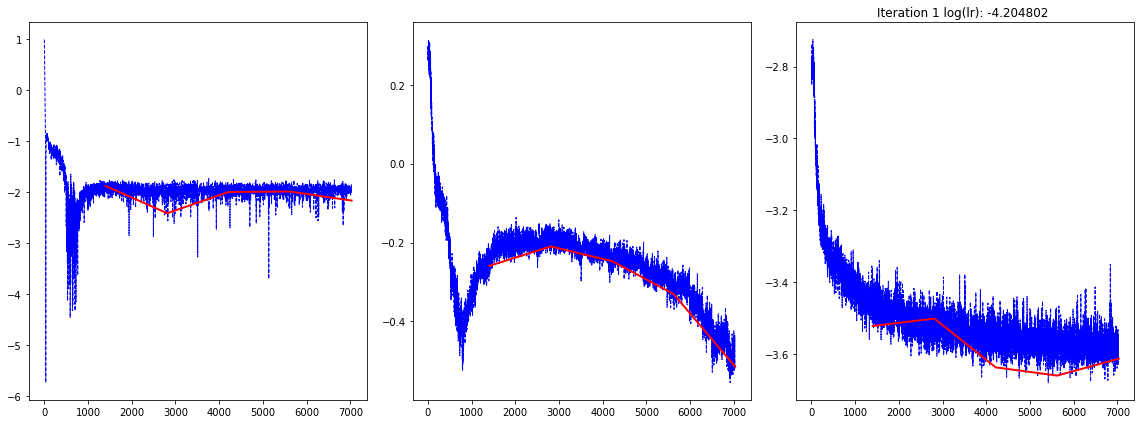

Epoch: 2-0/10 - 27(0.02) - disc_loss: -0.01146 - gen_loss: 0.34150 - vgg_loss: 2.39518  - mse_loss: 0.000290777
Epoch: 2-0/10 - 55(0.04) - disc_loss: -0.01121 - gen_loss: 0.31972 - vgg_loss: 2.36893  - mse_loss: 0.000255009
Epoch: 2-0/10 - 83(0.06) - disc_loss: -0.01162 - gen_loss: 0.31689 - vgg_loss: 2.21301  - mse_loss: 0.000231089
Epoch: 2-0/10 - 111(0.08) - disc_loss: -0.01210 - gen_loss: 0.34106 - vgg_loss: 2.39847  - mse_loss: 0.000246820
Epoch: 2-0/10 - 139(0.10) - disc_loss: -0.01164 - gen_loss: 0.31521 - vgg_loss: 2.34239  - mse_loss: 0.000249295
Epoch: 2-0/10 - 167(0.12) - disc_loss: -0.01088 - gen_loss: 0.36931 - vgg_loss: 2.62945  - mse_loss: 0.000315028
Epoch: 2-0/10 - 195(0.14) - disc_loss: -0.01129 - gen_loss: 0.30755 - vgg_loss: 2.35171  - mse_loss: 0.000251134
Epoch: 2-0/10 - 223(0.16) - disc_loss: -0.01447 - gen_loss: 0.30044 - vgg_loss: 2.43450  - mse_loss: 0.000284366
Epoch: 2-0/10 - 251(0.18) - disc_loss: -0.01010 - gen_loss: 0.30559 - vgg_loss: 2.38250  - mse_loss

Epoch: 2-1/10 - 643(0.46) - disc_loss: -0.01242 - gen_loss: 0.14356 - vgg_loss: 2.30800  - mse_loss: 0.000254607
Epoch: 2-1/10 - 671(0.48) - disc_loss: -0.01087 - gen_loss: 0.13398 - vgg_loss: 2.30371  - mse_loss: 0.000294803
Epoch: 2-1/10 - 699(0.50) - disc_loss: -0.01202 - gen_loss: 0.11614 - vgg_loss: 2.36201  - mse_loss: 0.000237605
Epoch: 2-1/10 - 727(0.52) - disc_loss: -0.01324 - gen_loss: 0.12486 - vgg_loss: 2.37438  - mse_loss: 0.000249660
Epoch: 2-1/10 - 755(0.54) - disc_loss: -0.01072 - gen_loss: 0.15567 - vgg_loss: 2.75423  - mse_loss: 0.000275875
Epoch: 2-1/10 - 783(0.56) - disc_loss: -0.01226 - gen_loss: 0.12176 - vgg_loss: 2.22822  - mse_loss: 0.000263926
Epoch: 2-1/10 - 811(0.58) - disc_loss: -0.00768 - gen_loss: 0.11858 - vgg_loss: 2.43824  - mse_loss: 0.000286412
Epoch: 2-1/10 - 839(0.60) - disc_loss: -0.01321 - gen_loss: 0.11783 - vgg_loss: 2.39390  - mse_loss: 0.000270644
Epoch: 2-1/10 - 867(0.62) - disc_loss: -0.01098 - gen_loss: 0.09704 - vgg_loss: 2.30761  - mse_l

Epoch: 2-2/10 - 1259(0.90) - disc_loss: -0.01232 - gen_loss: -0.11792 - vgg_loss: 2.02885  - mse_loss: 0.000230521
Epoch: 2-2/10 - 1287(0.92) - disc_loss: -0.01067 - gen_loss: -0.09041 - vgg_loss: 2.08069  - mse_loss: 0.000224718
Epoch: 2-2/10 - 1315(0.94) - disc_loss: -0.00867 - gen_loss: -0.07888 - vgg_loss: 2.18791  - mse_loss: 0.000280337
Epoch: 2-2/10 - 1343(0.96) - disc_loss: -0.01239 - gen_loss: -0.10077 - vgg_loss: 2.31467  - mse_loss: 0.000234227
Epoch: 2-2/10 - 1371(0.98) - disc_loss: -0.01137 - gen_loss: -0.09909 - vgg_loss: 2.18113  - mse_loss: 0.000267688
Epoch: 2-2/10 - 1399(1.00) - disc_loss: -0.01407 - gen_loss: -0.08520 - vgg_loss: 2.58887  - mse_loss: 0.000278034
Test....Epoch: 2-2/10 - disc_loss: -0.00845 - gen_loss: -0.11711 - vgg_loss: 2.18254 - mse_loss: 0.000226678
Epoch: 2-3/10 - 27(0.02) - disc_loss: -0.01294 - gen_loss: -0.12373 - vgg_loss: 2.20045  - mse_loss: 0.000244261
Epoch: 2-3/10 - 55(0.04) - disc_loss: -0.01111 - gen_loss: -0.08942 - vgg_loss: 2.37410 

Epoch: 2-4/10 - 419(0.30) - disc_loss: -0.01411 - gen_loss: -0.39374 - vgg_loss: 2.19290  - mse_loss: 0.000257070
Epoch: 2-4/10 - 447(0.32) - disc_loss: -0.01369 - gen_loss: -0.35483 - vgg_loss: 2.47926  - mse_loss: 0.000255176
Epoch: 2-4/10 - 475(0.34) - disc_loss: -0.01418 - gen_loss: -0.38751 - vgg_loss: 2.29711  - mse_loss: 0.000293027
Epoch: 2-4/10 - 503(0.36) - disc_loss: -0.01315 - gen_loss: -0.39666 - vgg_loss: 2.20081  - mse_loss: 0.000265840
Epoch: 2-4/10 - 531(0.38) - disc_loss: -0.01300 - gen_loss: -0.42263 - vgg_loss: 2.18575  - mse_loss: 0.000248922
Epoch: 2-4/10 - 559(0.40) - disc_loss: -0.01043 - gen_loss: -0.42723 - vgg_loss: 1.98280  - mse_loss: 0.000209454
Epoch: 2-4/10 - 587(0.42) - disc_loss: -0.01290 - gen_loss: -0.41876 - vgg_loss: 2.32363  - mse_loss: 0.000260412
Epoch: 2-4/10 - 615(0.44) - disc_loss: -0.01075 - gen_loss: -0.40791 - vgg_loss: 2.31915  - mse_loss: 0.000252098
Epoch: 2-4/10 - 643(0.46) - disc_loss: -0.01228 - gen_loss: -0.42785 - vgg_loss: 2.27652

<Figure size 432x288 with 0 Axes>

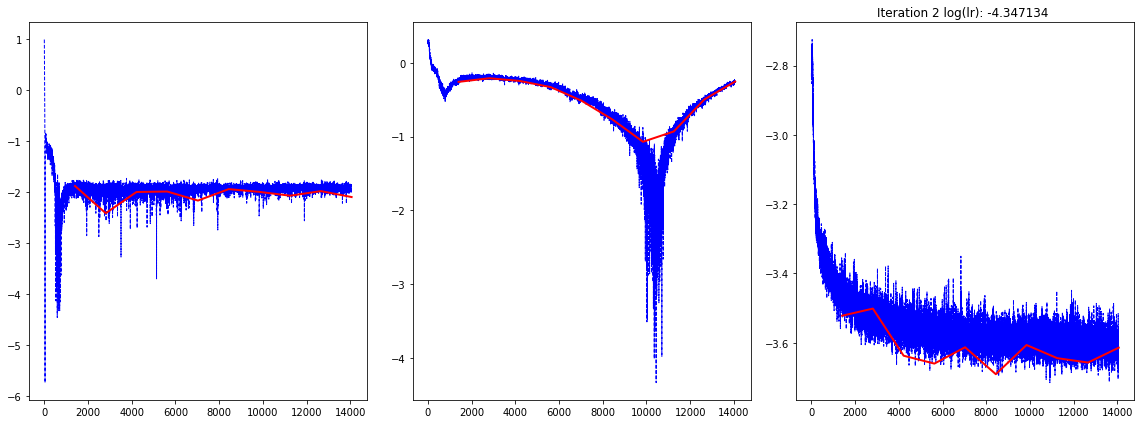

Epoch: 3-0/10 - 27(0.02) - disc_loss: -0.01259 - gen_loss: -0.53877 - vgg_loss: 2.38441  - mse_loss: 0.000226783
Epoch: 3-0/10 - 55(0.04) - disc_loss: -0.01266 - gen_loss: -0.55333 - vgg_loss: 2.32148  - mse_loss: 0.000255350
Epoch: 3-0/10 - 83(0.06) - disc_loss: -0.01396 - gen_loss: -0.54728 - vgg_loss: 2.41119  - mse_loss: 0.000249716
Epoch: 3-0/10 - 111(0.08) - disc_loss: -0.01073 - gen_loss: -0.57412 - vgg_loss: 2.07143  - mse_loss: 0.000218427
Epoch: 3-0/10 - 139(0.10) - disc_loss: -0.01321 - gen_loss: -0.55482 - vgg_loss: 2.31975  - mse_loss: 0.000245273
Epoch: 3-0/10 - 167(0.12) - disc_loss: -0.01147 - gen_loss: -0.57522 - vgg_loss: 2.16933  - mse_loss: 0.000223399
Epoch: 3-0/10 - 195(0.14) - disc_loss: -0.01136 - gen_loss: -0.57042 - vgg_loss: 2.08822  - mse_loss: 0.000231557
Epoch: 3-0/10 - 223(0.16) - disc_loss: -0.01187 - gen_loss: -0.56205 - vgg_loss: 2.31596  - mse_loss: 0.000230822
Epoch: 3-0/10 - 251(0.18) - disc_loss: -0.01241 - gen_loss: -0.59122 - vgg_loss: 2.18480  -

Epoch: 3-1/10 - 615(0.44) - disc_loss: -0.01063 - gen_loss: -0.67197 - vgg_loss: 2.38182  - mse_loss: 0.000275052
Epoch: 3-1/10 - 643(0.46) - disc_loss: -0.01225 - gen_loss: -0.68493 - vgg_loss: 2.14738  - mse_loss: 0.000247625
Epoch: 3-1/10 - 671(0.48) - disc_loss: -0.01358 - gen_loss: -0.69418 - vgg_loss: 2.32145  - mse_loss: 0.000245109
Epoch: 3-1/10 - 699(0.50) - disc_loss: -0.01306 - gen_loss: -0.68502 - vgg_loss: 2.56420  - mse_loss: 0.000261389
Epoch: 3-1/10 - 727(0.52) - disc_loss: -0.01087 - gen_loss: -0.70965 - vgg_loss: 2.08056  - mse_loss: 0.000242353
Epoch: 3-1/10 - 755(0.54) - disc_loss: -0.01297 - gen_loss: -0.68911 - vgg_loss: 2.20477  - mse_loss: 0.000249412
Epoch: 3-1/10 - 783(0.56) - disc_loss: -0.01473 - gen_loss: -0.73579 - vgg_loss: 1.97759  - mse_loss: 0.000237296
Epoch: 3-1/10 - 811(0.58) - disc_loss: -0.01258 - gen_loss: -0.72033 - vgg_loss: 2.08021  - mse_loss: 0.000243791
Epoch: 3-1/10 - 839(0.60) - disc_loss: -0.01338 - gen_loss: -0.69456 - vgg_loss: 2.26287

Epoch: 3-2/10 - 1203(0.86) - disc_loss: -0.01231 - gen_loss: -0.83726 - vgg_loss: 2.12599  - mse_loss: 0.000242371
Epoch: 3-2/10 - 1231(0.88) - disc_loss: -0.01320 - gen_loss: -0.82446 - vgg_loss: 2.01063  - mse_loss: 0.000259527
Epoch: 3-2/10 - 1259(0.90) - disc_loss: -0.01346 - gen_loss: -0.85020 - vgg_loss: 2.14119  - mse_loss: 0.000240625
Epoch: 3-2/10 - 1287(0.92) - disc_loss: -0.01299 - gen_loss: -0.82207 - vgg_loss: 2.12033  - mse_loss: 0.000223734
Epoch: 3-2/10 - 1315(0.94) - disc_loss: -0.01185 - gen_loss: -0.84564 - vgg_loss: 2.02601  - mse_loss: 0.000221287
Epoch: 3-2/10 - 1343(0.96) - disc_loss: -0.01166 - gen_loss: -0.84328 - vgg_loss: 1.99245  - mse_loss: 0.000201548
Epoch: 3-2/10 - 1371(0.98) - disc_loss: -0.01480 - gen_loss: -0.84878 - vgg_loss: 2.24498  - mse_loss: 0.000254374
Epoch: 3-2/10 - 1399(1.00) - disc_loss: -0.01459 - gen_loss: -0.83479 - vgg_loss: 2.21702  - mse_loss: 0.000231578
Test....Epoch: 3-2/10 - disc_loss: -0.01079 - gen_loss: -0.84821 - vgg_loss: 2.0

Epoch: 3-4/10 - 363(0.26) - disc_loss: -0.01321 - gen_loss: -0.93517 - vgg_loss: 2.19846  - mse_loss: 0.000241441
Epoch: 3-4/10 - 391(0.28) - disc_loss: -0.01391 - gen_loss: -0.93108 - vgg_loss: 2.30241  - mse_loss: 0.000247144
Epoch: 3-4/10 - 419(0.30) - disc_loss: -0.01193 - gen_loss: -0.96005 - vgg_loss: 2.27925  - mse_loss: 0.000221579
Epoch: 3-4/10 - 447(0.32) - disc_loss: -0.01342 - gen_loss: -0.94797 - vgg_loss: 1.99171  - mse_loss: 0.000244160
Epoch: 3-4/10 - 475(0.34) - disc_loss: -0.01246 - gen_loss: -0.96078 - vgg_loss: 2.31990  - mse_loss: 0.000259797
Epoch: 3-4/10 - 503(0.36) - disc_loss: -0.01561 - gen_loss: -0.93521 - vgg_loss: 2.36562  - mse_loss: 0.000263123
Epoch: 3-4/10 - 531(0.38) - disc_loss: -0.01163 - gen_loss: -0.96514 - vgg_loss: 2.07882  - mse_loss: 0.000225134
Epoch: 3-4/10 - 559(0.40) - disc_loss: -0.01502 - gen_loss: -0.96685 - vgg_loss: 2.12489  - mse_loss: 0.000240599
Epoch: 3-4/10 - 587(0.42) - disc_loss: -0.01433 - gen_loss: -0.99432 - vgg_loss: 2.04781

<Figure size 432x288 with 0 Axes>

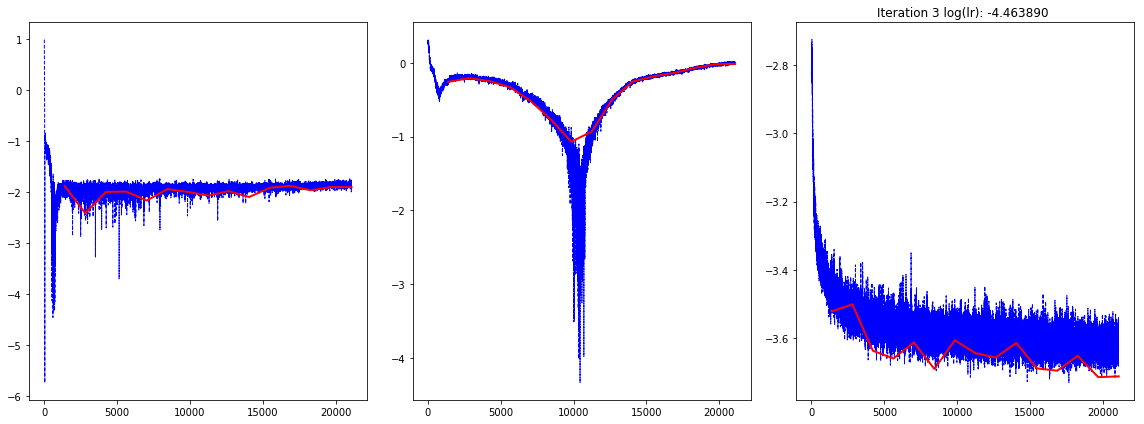

Epoch: 4-0/10 - 27(0.02) - disc_loss: -0.01367 - gen_loss: -1.01129 - vgg_loss: 1.92294  - mse_loss: 0.000255481
Epoch: 4-0/10 - 55(0.04) - disc_loss: -0.01514 - gen_loss: -0.97075 - vgg_loss: 2.52394  - mse_loss: 0.000236390
Epoch: 4-0/10 - 83(0.06) - disc_loss: -0.01371 - gen_loss: -1.01138 - vgg_loss: 2.11210  - mse_loss: 0.000242430
Epoch: 4-0/10 - 111(0.08) - disc_loss: -0.01476 - gen_loss: -0.99889 - vgg_loss: 2.11227  - mse_loss: 0.000239000
Epoch: 4-0/10 - 139(0.10) - disc_loss: -0.01409 - gen_loss: -1.02390 - vgg_loss: 2.08200  - mse_loss: 0.000235707
Epoch: 4-0/10 - 167(0.12) - disc_loss: -0.01220 - gen_loss: -1.00764 - vgg_loss: 1.98304  - mse_loss: 0.000204551
Epoch: 4-0/10 - 195(0.14) - disc_loss: -0.01456 - gen_loss: -1.03377 - vgg_loss: 1.95553  - mse_loss: 0.000247155
Epoch: 4-0/10 - 223(0.16) - disc_loss: -0.01366 - gen_loss: -1.00197 - vgg_loss: 2.13449  - mse_loss: 0.000243623
Epoch: 4-0/10 - 251(0.18) - disc_loss: -0.01455 - gen_loss: -1.02278 - vgg_loss: 2.13759  -

Epoch: 4-1/10 - 559(0.40) - disc_loss: -0.01356 - gen_loss: -1.09677 - vgg_loss: 2.21396  - mse_loss: 0.000238206
Epoch: 4-1/10 - 587(0.42) - disc_loss: -0.01260 - gen_loss: -1.06817 - vgg_loss: 2.07052  - mse_loss: 0.000256113
Epoch: 4-1/10 - 615(0.44) - disc_loss: -0.01400 - gen_loss: -1.00617 - vgg_loss: 2.41325  - mse_loss: 0.000255033
Epoch: 4-1/10 - 643(0.46) - disc_loss: -0.01405 - gen_loss: -1.05483 - vgg_loss: 2.33330  - mse_loss: 0.000234823
Epoch: 4-1/10 - 671(0.48) - disc_loss: -0.01418 - gen_loss: -1.10995 - vgg_loss: 2.04652  - mse_loss: 0.000217199
Epoch: 4-1/10 - 699(0.50) - disc_loss: -0.01278 - gen_loss: -1.09276 - vgg_loss: 2.07921  - mse_loss: 0.000236026
Epoch: 4-1/10 - 727(0.52) - disc_loss: -0.01426 - gen_loss: -1.10963 - vgg_loss: 2.04734  - mse_loss: 0.000227613
Epoch: 4-1/10 - 755(0.54) - disc_loss: -0.01374 - gen_loss: -1.06846 - vgg_loss: 2.23924  - mse_loss: 0.000225413
Epoch: 4-1/10 - 783(0.56) - disc_loss: -0.01419 - gen_loss: -1.12430 - vgg_loss: 1.92152

Epoch: 4-2/10 - 1147(0.82) - disc_loss: -0.01571 - gen_loss: -1.16949 - vgg_loss: 2.15108  - mse_loss: 0.000245889
Epoch: 4-2/10 - 1175(0.84) - disc_loss: -0.01458 - gen_loss: -1.16810 - vgg_loss: 2.07520  - mse_loss: 0.000226901
Epoch: 4-2/10 - 1203(0.86) - disc_loss: -0.01413 - gen_loss: -1.13202 - vgg_loss: 2.20673  - mse_loss: 0.000227854
Epoch: 4-2/10 - 1231(0.88) - disc_loss: -0.01488 - gen_loss: -1.17293 - vgg_loss: 2.05535  - mse_loss: 0.000236583
Epoch: 4-2/10 - 1259(0.90) - disc_loss: -0.01295 - gen_loss: -1.16069 - vgg_loss: 2.15176  - mse_loss: 0.000258024
Epoch: 4-2/10 - 1287(0.92) - disc_loss: -0.01427 - gen_loss: -1.12795 - vgg_loss: 2.06488  - mse_loss: 0.000232109
Epoch: 4-2/10 - 1315(0.94) - disc_loss: -0.01406 - gen_loss: -1.14953 - vgg_loss: 2.06005  - mse_loss: 0.000260675
Epoch: 4-2/10 - 1343(0.96) - disc_loss: -0.01353 - gen_loss: -1.13978 - vgg_loss: 2.14919  - mse_loss: 0.000222277
Epoch: 4-2/10 - 1371(0.98) - disc_loss: -0.01473 - gen_loss: -1.17732 - vgg_loss

Epoch: 4-4/10 - 307(0.22) - disc_loss: -0.01590 - gen_loss: -1.17649 - vgg_loss: 2.28494  - mse_loss: 0.000275062
Epoch: 4-4/10 - 335(0.24) - disc_loss: -0.01429 - gen_loss: -1.18564 - vgg_loss: 2.24426  - mse_loss: 0.000242414
Epoch: 4-4/10 - 363(0.26) - disc_loss: -0.01453 - gen_loss: -1.18855 - vgg_loss: 2.29852  - mse_loss: 0.000244133
Epoch: 4-4/10 - 391(0.28) - disc_loss: -0.01378 - gen_loss: -1.21290 - vgg_loss: 2.02607  - mse_loss: 0.000237569
Epoch: 4-4/10 - 419(0.30) - disc_loss: -0.01207 - gen_loss: -1.21931 - vgg_loss: 2.00370  - mse_loss: 0.000241248
Epoch: 4-4/10 - 447(0.32) - disc_loss: -0.01338 - gen_loss: -1.26260 - vgg_loss: 1.90491  - mse_loss: 0.000223038
Epoch: 4-4/10 - 475(0.34) - disc_loss: -0.01357 - gen_loss: -1.19349 - vgg_loss: 2.36894  - mse_loss: 0.000250434
Epoch: 4-4/10 - 503(0.36) - disc_loss: -0.01355 - gen_loss: -1.18787 - vgg_loss: 2.21455  - mse_loss: 0.000246297
Epoch: 4-4/10 - 531(0.38) - disc_loss: -0.01337 - gen_loss: -1.23297 - vgg_loss: 2.00139

<Figure size 432x288 with 0 Axes>

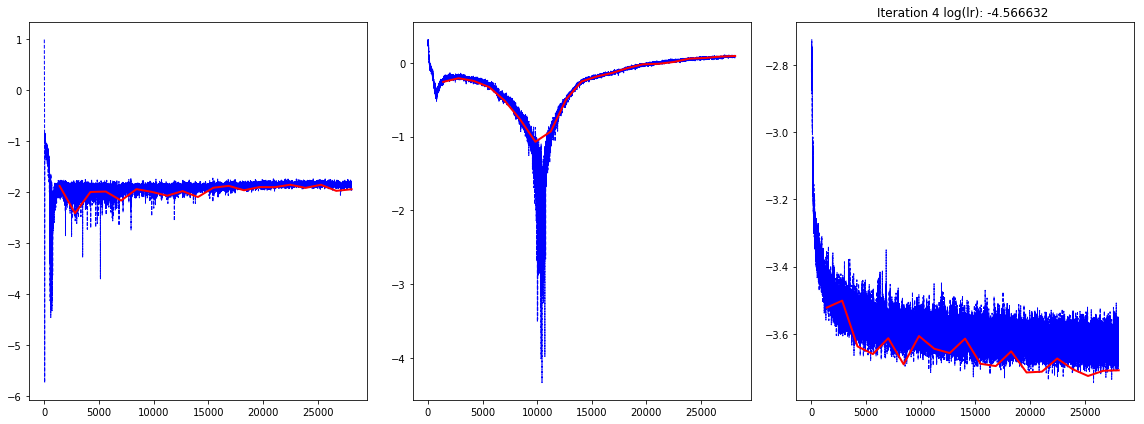

Epoch: 5-0/10 - 27(0.02) - disc_loss: -0.01280 - gen_loss: -1.21739 - vgg_loss: 1.88331  - mse_loss: 0.000242416
Epoch: 5-0/10 - 55(0.04) - disc_loss: -0.01444 - gen_loss: -1.20568 - vgg_loss: 2.22930  - mse_loss: 0.000232759
Epoch: 5-0/10 - 83(0.06) - disc_loss: -0.01391 - gen_loss: -1.24005 - vgg_loss: 2.08564  - mse_loss: 0.000214340
Epoch: 5-0/10 - 111(0.08) - disc_loss: -0.01356 - gen_loss: -1.24676 - vgg_loss: 2.14605  - mse_loss: 0.000239694
Epoch: 5-0/10 - 139(0.10) - disc_loss: -0.01247 - gen_loss: -1.23548 - vgg_loss: 2.02206  - mse_loss: 0.000227843
Epoch: 5-0/10 - 167(0.12) - disc_loss: -0.01395 - gen_loss: -1.18857 - vgg_loss: 2.26615  - mse_loss: 0.000234241
Epoch: 5-0/10 - 195(0.14) - disc_loss: -0.01538 - gen_loss: -1.23277 - vgg_loss: 2.10935  - mse_loss: 0.000249054
Epoch: 5-0/10 - 223(0.16) - disc_loss: -0.01330 - gen_loss: -1.26938 - vgg_loss: 1.86561  - mse_loss: 0.000234912
Epoch: 5-0/10 - 251(0.18) - disc_loss: -0.01274 - gen_loss: -1.22015 - vgg_loss: 2.06608  -

Epoch: 5-1/10 - 615(0.44) - disc_loss: -0.01309 - gen_loss: -1.29765 - vgg_loss: 1.92207  - mse_loss: 0.000219199
Epoch: 5-1/10 - 643(0.46) - disc_loss: -0.01348 - gen_loss: -1.25502 - vgg_loss: 2.34711  - mse_loss: 0.000235546
Epoch: 5-1/10 - 671(0.48) - disc_loss: -0.01439 - gen_loss: -1.27611 - vgg_loss: 2.15145  - mse_loss: 0.000222141
Epoch: 5-1/10 - 699(0.50) - disc_loss: -0.01425 - gen_loss: -1.30129 - vgg_loss: 1.98538  - mse_loss: 0.000219665
Epoch: 5-1/10 - 727(0.52) - disc_loss: -0.01236 - gen_loss: -1.29713 - vgg_loss: 1.91003  - mse_loss: 0.000209286
Epoch: 5-1/10 - 755(0.54) - disc_loss: -0.01309 - gen_loss: -1.26596 - vgg_loss: 2.09137  - mse_loss: 0.000224821
Epoch: 5-1/10 - 783(0.56) - disc_loss: -0.01388 - gen_loss: -1.31205 - vgg_loss: 1.94691  - mse_loss: 0.000252692
Epoch: 5-1/10 - 811(0.58) - disc_loss: -0.01370 - gen_loss: -1.29080 - vgg_loss: 1.98633  - mse_loss: 0.000254782
Epoch: 5-1/10 - 839(0.60) - disc_loss: -0.01432 - gen_loss: -1.26994 - vgg_loss: 2.14509

Epoch: 5-2/10 - 1203(0.86) - disc_loss: -0.01372 - gen_loss: -1.31992 - vgg_loss: 2.16659  - mse_loss: 0.000235268
Epoch: 5-2/10 - 1231(0.88) - disc_loss: -0.01261 - gen_loss: -1.31485 - vgg_loss: 2.06316  - mse_loss: 0.000232946
Epoch: 5-2/10 - 1259(0.90) - disc_loss: -0.01378 - gen_loss: -1.31957 - vgg_loss: 2.10925  - mse_loss: 0.000254527
Epoch: 5-2/10 - 1287(0.92) - disc_loss: -0.01506 - gen_loss: -1.30942 - vgg_loss: 2.30971  - mse_loss: 0.000246949
Epoch: 5-2/10 - 1315(0.94) - disc_loss: -0.01214 - gen_loss: -1.30573 - vgg_loss: 2.05436  - mse_loss: 0.000216994
Epoch: 5-2/10 - 1343(0.96) - disc_loss: -0.01119 - gen_loss: -1.35872 - vgg_loss: 1.77627  - mse_loss: 0.000187132
Epoch: 5-2/10 - 1371(0.98) - disc_loss: -0.01496 - gen_loss: -1.31646 - vgg_loss: 2.16410  - mse_loss: 0.000239728
Epoch: 5-2/10 - 1399(1.00) - disc_loss: -0.01371 - gen_loss: -1.33055 - vgg_loss: 2.21951  - mse_loss: 0.000220847
Test....Epoch: 5-2/10 - disc_loss: -0.01236 - gen_loss: -1.31147 - vgg_loss: 1.9

Epoch: 5-4/10 - 363(0.26) - disc_loss: -0.01220 - gen_loss: -1.35889 - vgg_loss: 1.89036  - mse_loss: 0.000236620
Epoch: 5-4/10 - 391(0.28) - disc_loss: -0.01211 - gen_loss: -1.36407 - vgg_loss: 1.83602  - mse_loss: 0.000186189
Epoch: 5-4/10 - 419(0.30) - disc_loss: -0.01336 - gen_loss: -1.35770 - vgg_loss: 2.09728  - mse_loss: 0.000233927
Epoch: 5-4/10 - 447(0.32) - disc_loss: -0.01362 - gen_loss: -1.34785 - vgg_loss: 2.25282  - mse_loss: 0.000250817
Epoch: 5-4/10 - 475(0.34) - disc_loss: -0.01263 - gen_loss: -1.36215 - vgg_loss: 1.93855  - mse_loss: 0.000225738
Epoch: 5-4/10 - 503(0.36) - disc_loss: -0.01353 - gen_loss: -1.36707 - vgg_loss: 1.92192  - mse_loss: 0.000235679
Epoch: 5-4/10 - 531(0.38) - disc_loss: -0.01138 - gen_loss: -1.32759 - vgg_loss: 2.06201  - mse_loss: 0.000226883
Epoch: 5-4/10 - 559(0.40) - disc_loss: -0.01331 - gen_loss: -1.35827 - vgg_loss: 2.02071  - mse_loss: 0.000239176
Epoch: 5-4/10 - 587(0.42) - disc_loss: -0.01223 - gen_loss: -1.35605 - vgg_loss: 2.10338

<Figure size 432x288 with 0 Axes>

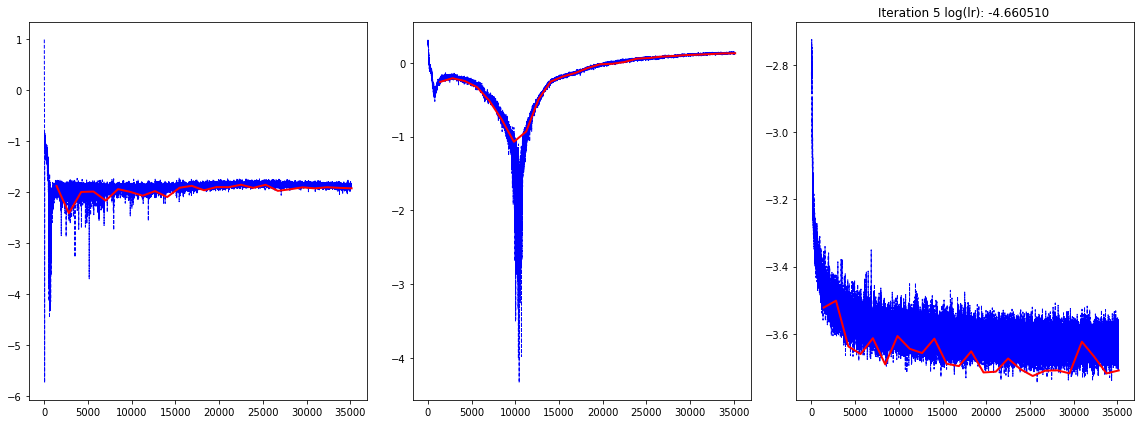

Epoch: 6-0/10 - 27(0.02) - disc_loss: -0.01223 - gen_loss: -1.35056 - vgg_loss: 2.30289  - mse_loss: 0.000226602
Epoch: 6-0/10 - 55(0.04) - disc_loss: -0.01282 - gen_loss: -1.39274 - vgg_loss: 1.82118  - mse_loss: 0.000211966
Epoch: 6-0/10 - 83(0.06) - disc_loss: -0.01344 - gen_loss: -1.33773 - vgg_loss: 2.20388  - mse_loss: 0.000252082
Epoch: 6-0/10 - 111(0.08) - disc_loss: -0.01363 - gen_loss: -1.37120 - vgg_loss: 2.03263  - mse_loss: 0.000221319
Epoch: 6-0/10 - 139(0.10) - disc_loss: -0.01314 - gen_loss: -1.37732 - vgg_loss: 1.87795  - mse_loss: 0.000233757
Epoch: 6-0/10 - 167(0.12) - disc_loss: -0.01328 - gen_loss: -1.37616 - vgg_loss: 1.93265  - mse_loss: 0.000241297
Epoch: 6-0/10 - 195(0.14) - disc_loss: -0.01311 - gen_loss: -1.36107 - vgg_loss: 2.14280  - mse_loss: 0.000241078
Epoch: 6-0/10 - 223(0.16) - disc_loss: -0.01282 - gen_loss: -1.36323 - vgg_loss: 2.06989  - mse_loss: 0.000247910
Epoch: 6-0/10 - 251(0.18) - disc_loss: -0.01113 - gen_loss: -1.38636 - vgg_loss: 1.96276  -

Epoch: 6-1/10 - 615(0.44) - disc_loss: -0.01090 - gen_loss: -1.43965 - vgg_loss: 2.03964  - mse_loss: 0.000224645
Epoch: 6-1/10 - 643(0.46) - disc_loss: -0.01181 - gen_loss: -1.43227 - vgg_loss: 1.85478  - mse_loss: 0.000201946
Epoch: 6-1/10 - 671(0.48) - disc_loss: -0.01130 - gen_loss: -1.41003 - vgg_loss: 2.07560  - mse_loss: 0.000222517
Epoch: 6-1/10 - 699(0.50) - disc_loss: -0.01160 - gen_loss: -1.39198 - vgg_loss: 2.11360  - mse_loss: 0.000222676
Epoch: 6-1/10 - 727(0.52) - disc_loss: -0.01333 - gen_loss: -1.42215 - vgg_loss: 2.06703  - mse_loss: 0.000250475
Epoch: 6-1/10 - 755(0.54) - disc_loss: -0.01231 - gen_loss: -1.43014 - vgg_loss: 1.99287  - mse_loss: 0.000222625
Epoch: 6-1/10 - 783(0.56) - disc_loss: -0.01106 - gen_loss: -1.42551 - vgg_loss: 1.91715  - mse_loss: 0.000209994
Epoch: 6-1/10 - 811(0.58) - disc_loss: -0.01408 - gen_loss: -1.44608 - vgg_loss: 1.96233  - mse_loss: 0.000236093
Epoch: 6-1/10 - 839(0.60) - disc_loss: -0.01190 - gen_loss: -1.43718 - vgg_loss: 2.05304

Epoch: 6-2/10 - 1203(0.86) - disc_loss: -0.01386 - gen_loss: -1.47809 - vgg_loss: 1.97152  - mse_loss: 0.000241757
Epoch: 6-2/10 - 1231(0.88) - disc_loss: -0.01232 - gen_loss: -1.46704 - vgg_loss: 2.07049  - mse_loss: 0.000248426
Epoch: 6-2/10 - 1259(0.90) - disc_loss: -0.01111 - gen_loss: -1.49514 - vgg_loss: 1.99211  - mse_loss: 0.000235796
Epoch: 6-2/10 - 1287(0.92) - disc_loss: -0.01222 - gen_loss: -1.45503 - vgg_loss: 2.07094  - mse_loss: 0.000239274
Epoch: 6-2/10 - 1315(0.94) - disc_loss: -0.01152 - gen_loss: -1.49278 - vgg_loss: 1.88502  - mse_loss: 0.000207440
Epoch: 6-2/10 - 1343(0.96) - disc_loss: -0.01416 - gen_loss: -1.49556 - vgg_loss: 2.03640  - mse_loss: 0.000240614
Epoch: 6-2/10 - 1371(0.98) - disc_loss: -0.01116 - gen_loss: -1.45518 - vgg_loss: 2.17494  - mse_loss: 0.000236789
Epoch: 6-2/10 - 1399(1.00) - disc_loss: -0.01347 - gen_loss: -1.45809 - vgg_loss: 2.09066  - mse_loss: 0.000247803
Test....Epoch: 6-2/10 - disc_loss: -0.01145 - gen_loss: -1.47338 - vgg_loss: 1.9

Epoch: 6-4/10 - 363(0.26) - disc_loss: -0.01231 - gen_loss: -1.51966 - vgg_loss: 2.09908  - mse_loss: 0.000246793
Epoch: 6-4/10 - 391(0.28) - disc_loss: -0.01270 - gen_loss: -1.55128 - vgg_loss: 1.79569  - mse_loss: 0.000220694
Epoch: 6-4/10 - 419(0.30) - disc_loss: -0.01233 - gen_loss: -1.54599 - vgg_loss: 2.05490  - mse_loss: 0.000222870
Epoch: 6-4/10 - 447(0.32) - disc_loss: -0.01164 - gen_loss: -1.52032 - vgg_loss: 2.17538  - mse_loss: 0.000240203
Epoch: 6-4/10 - 475(0.34) - disc_loss: -0.01281 - gen_loss: -1.52373 - vgg_loss: 2.00861  - mse_loss: 0.000227925
Epoch: 6-4/10 - 503(0.36) - disc_loss: -0.01142 - gen_loss: -1.50087 - vgg_loss: 2.20085  - mse_loss: 0.000234015
Epoch: 6-4/10 - 531(0.38) - disc_loss: -0.01261 - gen_loss: -1.54375 - vgg_loss: 1.92735  - mse_loss: 0.000221572
Epoch: 6-4/10 - 559(0.40) - disc_loss: -0.01152 - gen_loss: -1.54504 - vgg_loss: 1.91762  - mse_loss: 0.000230033
Epoch: 6-4/10 - 587(0.42) - disc_loss: -0.01032 - gen_loss: -1.53608 - vgg_loss: 1.95459

<Figure size 432x288 with 0 Axes>

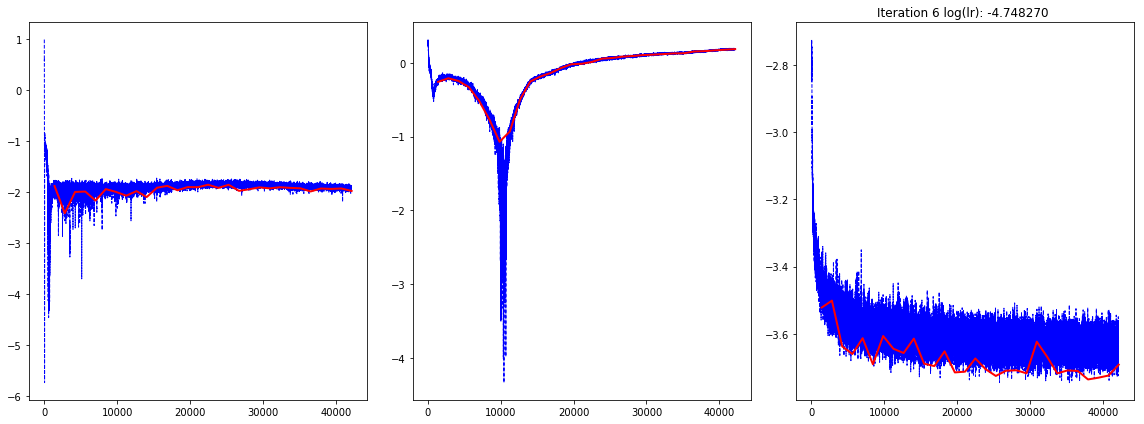

Epoch: 7-0/10 - 27(0.02) - disc_loss: -0.01038 - gen_loss: -1.50024 - vgg_loss: 2.10327  - mse_loss: 0.000215228
Epoch: 7-0/10 - 55(0.04) - disc_loss: -0.01265 - gen_loss: -1.53997 - vgg_loss: 2.04579  - mse_loss: 0.000249185
Epoch: 7-0/10 - 83(0.06) - disc_loss: -0.01285 - gen_loss: -1.52529 - vgg_loss: 2.14913  - mse_loss: 0.000232769
Epoch: 7-0/10 - 111(0.08) - disc_loss: -0.01173 - gen_loss: -1.55136 - vgg_loss: 1.99164  - mse_loss: 0.000227237
Epoch: 7-0/10 - 139(0.10) - disc_loss: -0.01186 - gen_loss: -1.55272 - vgg_loss: 1.96947  - mse_loss: 0.000248378
Epoch: 7-0/10 - 167(0.12) - disc_loss: -0.01126 - gen_loss: -1.54094 - vgg_loss: 1.86435  - mse_loss: 0.000215976
Epoch: 7-0/10 - 195(0.14) - disc_loss: -0.01275 - gen_loss: -1.54724 - vgg_loss: 2.05237  - mse_loss: 0.000225768
Epoch: 7-0/10 - 223(0.16) - disc_loss: -0.01323 - gen_loss: -1.55653 - vgg_loss: 1.95639  - mse_loss: 0.000232407
Epoch: 7-0/10 - 251(0.18) - disc_loss: -0.01132 - gen_loss: -1.55407 - vgg_loss: 1.92960  -

Epoch: 7-1/10 - 615(0.44) - disc_loss: -0.01089 - gen_loss: -1.50084 - vgg_loss: 2.28804  - mse_loss: 0.000236903
Epoch: 7-1/10 - 643(0.46) - disc_loss: -0.01257 - gen_loss: -1.56545 - vgg_loss: 1.93436  - mse_loss: 0.000231748
Epoch: 7-1/10 - 671(0.48) - disc_loss: -0.01196 - gen_loss: -1.54927 - vgg_loss: 1.98747  - mse_loss: 0.000235480
Epoch: 7-1/10 - 699(0.50) - disc_loss: -0.01201 - gen_loss: -1.56527 - vgg_loss: 1.91028  - mse_loss: 0.000228933
Epoch: 7-1/10 - 727(0.52) - disc_loss: -0.01128 - gen_loss: -1.56443 - vgg_loss: 1.88212  - mse_loss: 0.000240018
Epoch: 7-1/10 - 755(0.54) - disc_loss: -0.01252 - gen_loss: -1.56296 - vgg_loss: 1.94415  - mse_loss: 0.000225527
Epoch: 7-1/10 - 783(0.56) - disc_loss: -0.01232 - gen_loss: -1.56222 - vgg_loss: 2.07691  - mse_loss: 0.000235511
Epoch: 7-1/10 - 811(0.58) - disc_loss: -0.01128 - gen_loss: -1.56501 - vgg_loss: 1.96107  - mse_loss: 0.000221861
Epoch: 7-1/10 - 839(0.60) - disc_loss: -0.01131 - gen_loss: -1.55193 - vgg_loss: 2.04237

Epoch: 7-2/10 - 1203(0.86) - disc_loss: -0.01063 - gen_loss: -1.56998 - vgg_loss: 2.05703  - mse_loss: 0.000205734
Epoch: 7-2/10 - 1231(0.88) - disc_loss: -0.01191 - gen_loss: -1.53245 - vgg_loss: 2.20306  - mse_loss: 0.000246007
Epoch: 7-2/10 - 1259(0.90) - disc_loss: -0.01077 - gen_loss: -1.57238 - vgg_loss: 1.83303  - mse_loss: 0.000203671
Epoch: 7-2/10 - 1287(0.92) - disc_loss: -0.01226 - gen_loss: -1.56426 - vgg_loss: 2.12359  - mse_loss: 0.000219350
Epoch: 7-2/10 - 1315(0.94) - disc_loss: -0.01124 - gen_loss: -1.60141 - vgg_loss: 1.74444  - mse_loss: 0.000213253
Epoch: 7-2/10 - 1343(0.96) - disc_loss: -0.01371 - gen_loss: -1.56021 - vgg_loss: 2.30888  - mse_loss: 0.000243479
Epoch: 7-2/10 - 1371(0.98) - disc_loss: -0.01196 - gen_loss: -1.58564 - vgg_loss: 1.96836  - mse_loss: 0.000250652
Epoch: 7-2/10 - 1399(1.00) - disc_loss: -0.01141 - gen_loss: -1.59185 - vgg_loss: 1.89817  - mse_loss: 0.000239682
Test....Epoch: 7-2/10 - disc_loss: -0.01104 - gen_loss: -1.55483 - vgg_loss: 1.9

Epoch: 7-4/10 - 363(0.26) - disc_loss: -0.01223 - gen_loss: -1.58703 - vgg_loss: 2.23736  - mse_loss: 0.000262907
Epoch: 7-4/10 - 391(0.28) - disc_loss: -0.01136 - gen_loss: -1.54827 - vgg_loss: 2.35406  - mse_loss: 0.000246163
Epoch: 7-4/10 - 419(0.30) - disc_loss: -0.01231 - gen_loss: -1.60253 - vgg_loss: 1.95931  - mse_loss: 0.000252689
Epoch: 7-4/10 - 447(0.32) - disc_loss: -0.01058 - gen_loss: -1.58629 - vgg_loss: 2.07060  - mse_loss: 0.000225735
Epoch: 7-4/10 - 475(0.34) - disc_loss: -0.01162 - gen_loss: -1.57565 - vgg_loss: 2.11050  - mse_loss: 0.000227723
Epoch: 7-4/10 - 503(0.36) - disc_loss: -0.01112 - gen_loss: -1.58893 - vgg_loss: 1.88537  - mse_loss: 0.000225963
Epoch: 7-4/10 - 531(0.38) - disc_loss: -0.01090 - gen_loss: -1.59112 - vgg_loss: 1.93764  - mse_loss: 0.000213892
Epoch: 7-4/10 - 559(0.40) - disc_loss: -0.01131 - gen_loss: -1.62573 - vgg_loss: 1.68840  - mse_loss: 0.000186621
Epoch: 7-4/10 - 587(0.42) - disc_loss: -0.01248 - gen_loss: -1.60705 - vgg_loss: 1.90811

<Figure size 432x288 with 0 Axes>

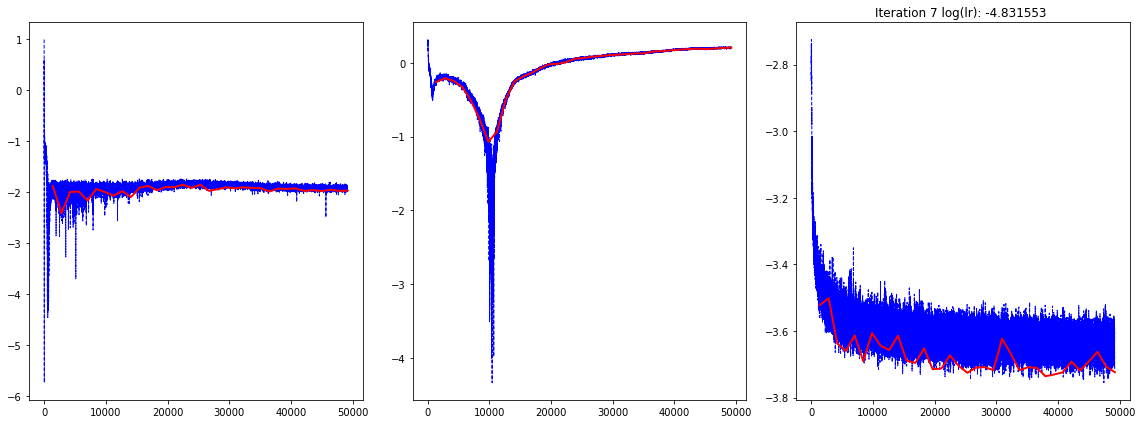

Epoch: 8-0/10 - 27(0.02) - disc_loss: -0.01216 - gen_loss: -1.61215 - vgg_loss: 2.03039  - mse_loss: 0.000212858
Epoch: 8-0/10 - 55(0.04) - disc_loss: -0.01233 - gen_loss: -1.59819 - vgg_loss: 2.11311  - mse_loss: 0.000237961
Epoch: 8-0/10 - 83(0.06) - disc_loss: -0.01052 - gen_loss: -1.61960 - vgg_loss: 1.88914  - mse_loss: 0.000224584
Epoch: 8-0/10 - 111(0.08) - disc_loss: -0.01192 - gen_loss: -1.57353 - vgg_loss: 2.18081  - mse_loss: 0.000249212
Epoch: 8-0/10 - 139(0.10) - disc_loss: -0.01243 - gen_loss: -1.62348 - vgg_loss: 1.90797  - mse_loss: 0.000207038
Epoch: 8-0/10 - 167(0.12) - disc_loss: -0.01193 - gen_loss: -1.62305 - vgg_loss: 1.90207  - mse_loss: 0.000214592
Epoch: 8-0/10 - 195(0.14) - disc_loss: -0.01241 - gen_loss: -1.61576 - vgg_loss: 1.99870  - mse_loss: 0.000246927
Epoch: 8-0/10 - 223(0.16) - disc_loss: -0.01091 - gen_loss: -1.57861 - vgg_loss: 2.18477  - mse_loss: 0.000228137
Epoch: 8-0/10 - 251(0.18) - disc_loss: -0.01200 - gen_loss: -1.58133 - vgg_loss: 2.05904  -

Epoch: 8-1/10 - 615(0.44) - disc_loss: -0.01102 - gen_loss: -1.58881 - vgg_loss: 1.99092  - mse_loss: 0.000206513
Epoch: 8-1/10 - 643(0.46) - disc_loss: -0.01246 - gen_loss: -1.60131 - vgg_loss: 1.99166  - mse_loss: 0.000223202
Epoch: 8-1/10 - 671(0.48) - disc_loss: -0.01234 - gen_loss: -1.58519 - vgg_loss: 2.02002  - mse_loss: 0.000230068
Epoch: 8-1/10 - 699(0.50) - disc_loss: -0.01136 - gen_loss: -1.59879 - vgg_loss: 1.86834  - mse_loss: 0.000227029
Epoch: 8-1/10 - 727(0.52) - disc_loss: -0.01111 - gen_loss: -1.56554 - vgg_loss: 2.09701  - mse_loss: 0.000235949
Epoch: 8-1/10 - 755(0.54) - disc_loss: -0.01132 - gen_loss: -1.59889 - vgg_loss: 1.94477  - mse_loss: 0.000223673
Epoch: 8-1/10 - 783(0.56) - disc_loss: -0.01158 - gen_loss: -1.58095 - vgg_loss: 2.04085  - mse_loss: 0.000223119
Epoch: 8-1/10 - 811(0.58) - disc_loss: -0.01134 - gen_loss: -1.59594 - vgg_loss: 1.96189  - mse_loss: 0.000244143
Epoch: 8-1/10 - 839(0.60) - disc_loss: -0.01147 - gen_loss: -1.58131 - vgg_loss: 1.97762

Epoch: 8-2/10 - 1203(0.86) - disc_loss: -0.01286 - gen_loss: -1.57715 - vgg_loss: 2.21431  - mse_loss: 0.000240235
Epoch: 8-2/10 - 1231(0.88) - disc_loss: -0.01163 - gen_loss: -1.61797 - vgg_loss: 1.93883  - mse_loss: 0.000202156
Epoch: 8-2/10 - 1259(0.90) - disc_loss: -0.01022 - gen_loss: -1.63303 - vgg_loss: 1.85466  - mse_loss: 0.000219856
Epoch: 8-2/10 - 1287(0.92) - disc_loss: -0.01092 - gen_loss: -1.62089 - vgg_loss: 1.88553  - mse_loss: 0.000231663
Epoch: 8-2/10 - 1315(0.94) - disc_loss: -0.01092 - gen_loss: -1.60573 - vgg_loss: 1.90134  - mse_loss: 0.000224773
Epoch: 8-2/10 - 1343(0.96) - disc_loss: -0.01139 - gen_loss: -1.60160 - vgg_loss: 2.00173  - mse_loss: 0.000209944
Epoch: 8-2/10 - 1371(0.98) - disc_loss: -0.01171 - gen_loss: -1.58977 - vgg_loss: 2.16025  - mse_loss: 0.000239310
Epoch: 8-2/10 - 1399(1.00) - disc_loss: -0.01157 - gen_loss: -1.59404 - vgg_loss: 2.06140  - mse_loss: 0.000252929
Test....Epoch: 8-2/10 - disc_loss: -0.01034 - gen_loss: -1.59434 - vgg_loss: 1.8

Epoch: 8-4/10 - 363(0.26) - disc_loss: -0.01118 - gen_loss: -1.62790 - vgg_loss: 1.80946  - mse_loss: 0.000230108
Epoch: 8-4/10 - 391(0.28) - disc_loss: -0.01156 - gen_loss: -1.62770 - vgg_loss: 1.93752  - mse_loss: 0.000235961
Epoch: 8-4/10 - 419(0.30) - disc_loss: -0.01160 - gen_loss: -1.60208 - vgg_loss: 2.15928  - mse_loss: 0.000229577
Epoch: 8-4/10 - 447(0.32) - disc_loss: -0.01268 - gen_loss: -1.62997 - vgg_loss: 1.95960  - mse_loss: 0.000250341
Epoch: 8-4/10 - 475(0.34) - disc_loss: -0.01367 - gen_loss: -1.62085 - vgg_loss: 2.08030  - mse_loss: 0.000235546
Epoch: 8-4/10 - 503(0.36) - disc_loss: -0.01121 - gen_loss: -1.61135 - vgg_loss: 2.03041  - mse_loss: 0.000251467
Epoch: 8-4/10 - 531(0.38) - disc_loss: -0.01026 - gen_loss: -1.61540 - vgg_loss: 2.00993  - mse_loss: 0.000241835
Epoch: 8-4/10 - 559(0.40) - disc_loss: -0.01133 - gen_loss: -1.62294 - vgg_loss: 1.81996  - mse_loss: 0.000225276
Epoch: 8-4/10 - 587(0.42) - disc_loss: -0.01167 - gen_loss: -1.60948 - vgg_loss: 1.92117

<Figure size 432x288 with 0 Axes>

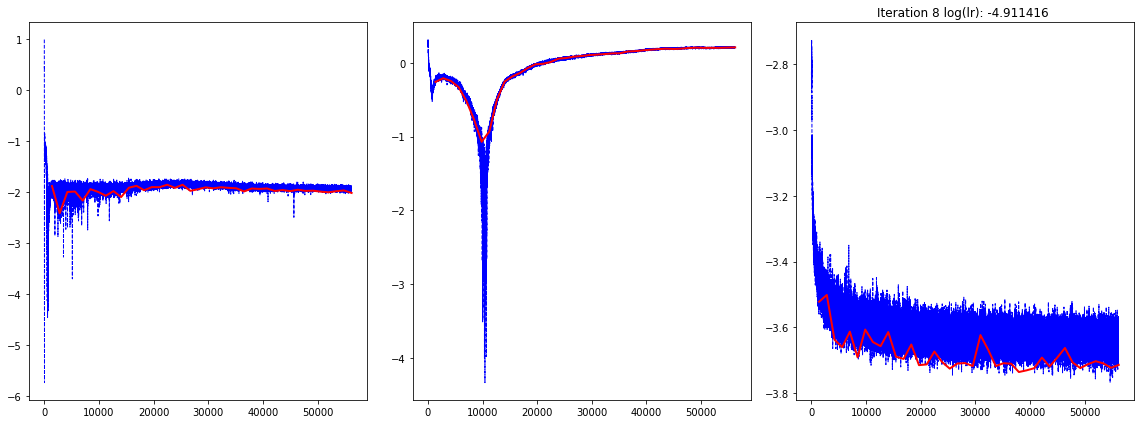

Epoch: 9-0/10 - 27(0.02) - disc_loss: -0.01219 - gen_loss: -1.59590 - vgg_loss: 2.23852  - mse_loss: 0.000242197
Epoch: 9-0/10 - 55(0.04) - disc_loss: -0.01164 - gen_loss: -1.58578 - vgg_loss: 2.26234  - mse_loss: 0.000268085
Epoch: 9-0/10 - 83(0.06) - disc_loss: -0.01086 - gen_loss: -1.61836 - vgg_loss: 1.81175  - mse_loss: 0.000220217
Epoch: 9-0/10 - 111(0.08) - disc_loss: -0.01178 - gen_loss: -1.57445 - vgg_loss: 2.24896  - mse_loss: 0.000275803
Epoch: 9-0/10 - 139(0.10) - disc_loss: -0.01152 - gen_loss: -1.63056 - vgg_loss: 1.80557  - mse_loss: 0.000192581
Epoch: 9-0/10 - 167(0.12) - disc_loss: -0.01311 - gen_loss: -1.58981 - vgg_loss: 2.29778  - mse_loss: 0.000267158
Epoch: 9-0/10 - 195(0.14) - disc_loss: -0.01206 - gen_loss: -1.62235 - vgg_loss: 1.97103  - mse_loss: 0.000216312
Epoch: 9-0/10 - 223(0.16) - disc_loss: -0.01168 - gen_loss: -1.62374 - vgg_loss: 1.95092  - mse_loss: 0.000247760
Epoch: 9-0/10 - 251(0.18) - disc_loss: -0.01225 - gen_loss: -1.57895 - vgg_loss: 2.25002  -

Epoch: 9-1/10 - 615(0.44) - disc_loss: -0.01210 - gen_loss: -1.63737 - vgg_loss: 1.81570  - mse_loss: 0.000219341
Epoch: 9-1/10 - 643(0.46) - disc_loss: -0.01044 - gen_loss: -1.61177 - vgg_loss: 1.99409  - mse_loss: 0.000244938
Epoch: 9-1/10 - 671(0.48) - disc_loss: -0.01279 - gen_loss: -1.63550 - vgg_loss: 1.92778  - mse_loss: 0.000245358
Epoch: 9-1/10 - 699(0.50) - disc_loss: -0.01006 - gen_loss: -1.64131 - vgg_loss: 1.85584  - mse_loss: 0.000212833
Epoch: 9-1/10 - 727(0.52) - disc_loss: -0.01139 - gen_loss: -1.64763 - vgg_loss: 1.81294  - mse_loss: 0.000219917
Epoch: 9-1/10 - 755(0.54) - disc_loss: -0.01214 - gen_loss: -1.62546 - vgg_loss: 1.98616  - mse_loss: 0.000243032
Epoch: 9-1/10 - 783(0.56) - disc_loss: -0.01056 - gen_loss: -1.61517 - vgg_loss: 1.99727  - mse_loss: 0.000212535
Epoch: 9-1/10 - 811(0.58) - disc_loss: -0.01154 - gen_loss: -1.61948 - vgg_loss: 1.96992  - mse_loss: 0.000254554
Epoch: 9-1/10 - 839(0.60) - disc_loss: -0.01063 - gen_loss: -1.59419 - vgg_loss: 1.97730

Epoch: 9-2/10 - 1203(0.86) - disc_loss: -0.01069 - gen_loss: -1.63066 - vgg_loss: 1.93453  - mse_loss: 0.000226749
Epoch: 9-2/10 - 1231(0.88) - disc_loss: -0.01192 - gen_loss: -1.60272 - vgg_loss: 2.18182  - mse_loss: 0.000234620
Epoch: 9-2/10 - 1259(0.90) - disc_loss: -0.01168 - gen_loss: -1.63960 - vgg_loss: 1.93560  - mse_loss: 0.000217277
Epoch: 9-2/10 - 1287(0.92) - disc_loss: -0.01208 - gen_loss: -1.61603 - vgg_loss: 2.11710  - mse_loss: 0.000249512
Epoch: 9-2/10 - 1315(0.94) - disc_loss: -0.01120 - gen_loss: -1.62679 - vgg_loss: 1.93331  - mse_loss: 0.000228015
Epoch: 9-2/10 - 1343(0.96) - disc_loss: -0.01157 - gen_loss: -1.59649 - vgg_loss: 2.23454  - mse_loss: 0.000228824
Epoch: 9-2/10 - 1371(0.98) - disc_loss: -0.01200 - gen_loss: -1.62355 - vgg_loss: 1.98413  - mse_loss: 0.000229634
Epoch: 9-2/10 - 1399(1.00) - disc_loss: -0.01112 - gen_loss: -1.62749 - vgg_loss: 1.93424  - mse_loss: 0.000232225
Test....Epoch: 9-2/10 - disc_loss: -0.00980 - gen_loss: -1.63821 - vgg_loss: 1.8

Epoch: 9-4/10 - 363(0.26) - disc_loss: -0.01061 - gen_loss: -1.63960 - vgg_loss: 1.94313  - mse_loss: 0.000229851
Epoch: 9-4/10 - 391(0.28) - disc_loss: -0.01101 - gen_loss: -1.60998 - vgg_loss: 2.28162  - mse_loss: 0.000259215
Epoch: 9-4/10 - 419(0.30) - disc_loss: -0.01207 - gen_loss: -1.59667 - vgg_loss: 2.28283  - mse_loss: 0.000266146
Epoch: 9-4/10 - 447(0.32) - disc_loss: -0.01154 - gen_loss: -1.64655 - vgg_loss: 1.98068  - mse_loss: 0.000211896
Epoch: 9-4/10 - 475(0.34) - disc_loss: -0.01221 - gen_loss: -1.66561 - vgg_loss: 1.83210  - mse_loss: 0.000224655
Epoch: 9-4/10 - 503(0.36) - disc_loss: -0.01182 - gen_loss: -1.63463 - vgg_loss: 2.10599  - mse_loss: 0.000215175
Epoch: 9-4/10 - 531(0.38) - disc_loss: -0.01059 - gen_loss: -1.65529 - vgg_loss: 1.89613  - mse_loss: 0.000209692
Epoch: 9-4/10 - 559(0.40) - disc_loss: -0.01146 - gen_loss: -1.64410 - vgg_loss: 2.05843  - mse_loss: 0.000209541
Epoch: 9-4/10 - 587(0.42) - disc_loss: -0.01146 - gen_loss: -1.61726 - vgg_loss: 2.26972

<Figure size 432x288 with 0 Axes>

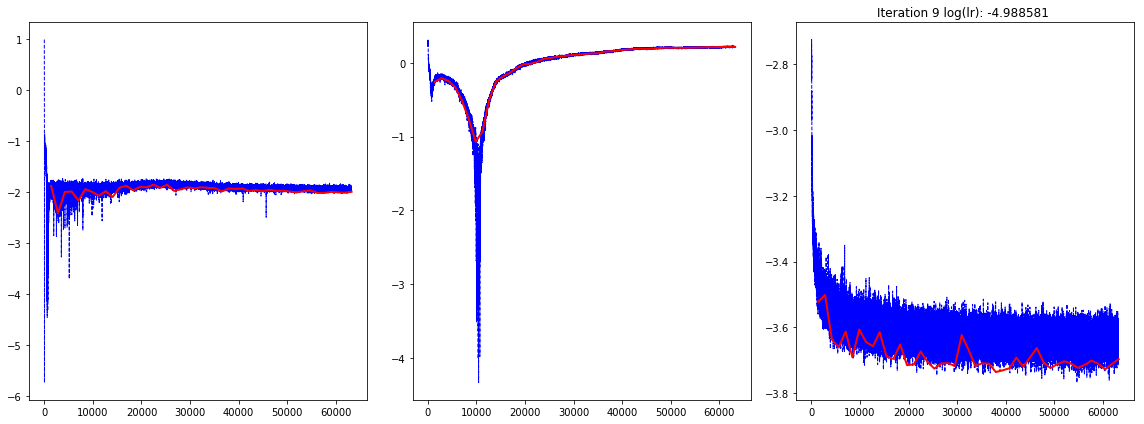

Epoch: 10-0/10 - 27(0.02) - disc_loss: -0.01196 - gen_loss: -1.64230 - vgg_loss: 2.07705  - mse_loss: 0.000249409
Epoch: 10-0/10 - 55(0.04) - disc_loss: -0.01204 - gen_loss: -1.65344 - vgg_loss: 2.00005  - mse_loss: 0.000249795
Epoch: 10-0/10 - 83(0.06) - disc_loss: -0.01196 - gen_loss: -1.65433 - vgg_loss: 2.01583  - mse_loss: 0.000236047
Epoch: 10-0/10 - 111(0.08) - disc_loss: -0.01109 - gen_loss: -1.64171 - vgg_loss: 1.97415  - mse_loss: 0.000218231
Epoch: 10-0/10 - 139(0.10) - disc_loss: -0.01167 - gen_loss: -1.64669 - vgg_loss: 2.02368  - mse_loss: 0.000233135
Epoch: 10-0/10 - 167(0.12) - disc_loss: -0.01172 - gen_loss: -1.63919 - vgg_loss: 2.10541  - mse_loss: 0.000230392
Epoch: 10-0/10 - 195(0.14) - disc_loss: -0.01128 - gen_loss: -1.66014 - vgg_loss: 1.91221  - mse_loss: 0.000210175
Epoch: 10-0/10 - 223(0.16) - disc_loss: -0.01156 - gen_loss: -1.63657 - vgg_loss: 2.05615  - mse_loss: 0.000220902
Epoch: 10-0/10 - 251(0.18) - disc_loss: -0.01040 - gen_loss: -1.65718 - vgg_loss: 1

Epoch: 10-1/10 - 615(0.44) - disc_loss: -0.01189 - gen_loss: -1.67438 - vgg_loss: 1.89033  - mse_loss: 0.000193946
Epoch: 10-1/10 - 643(0.46) - disc_loss: -0.01112 - gen_loss: -1.67682 - vgg_loss: 1.86659  - mse_loss: 0.000211242
Epoch: 10-1/10 - 671(0.48) - disc_loss: -0.01231 - gen_loss: -1.65333 - vgg_loss: 2.12415  - mse_loss: 0.000226317
Epoch: 10-1/10 - 699(0.50) - disc_loss: -0.01286 - gen_loss: -1.64712 - vgg_loss: 2.26511  - mse_loss: 0.000244727
Epoch: 10-1/10 - 727(0.52) - disc_loss: -0.01173 - gen_loss: -1.69296 - vgg_loss: 1.77015  - mse_loss: 0.000219845
Epoch: 10-1/10 - 755(0.54) - disc_loss: -0.01190 - gen_loss: -1.65328 - vgg_loss: 2.18522  - mse_loss: 0.000225560
Epoch: 10-1/10 - 783(0.56) - disc_loss: -0.01103 - gen_loss: -1.67674 - vgg_loss: 1.89282  - mse_loss: 0.000189387
Epoch: 10-1/10 - 811(0.58) - disc_loss: -0.01105 - gen_loss: -1.66778 - vgg_loss: 1.84637  - mse_loss: 0.000243746
Epoch: 10-1/10 - 839(0.60) - disc_loss: -0.01120 - gen_loss: -1.63539 - vgg_loss

Epoch: 10-2/10 - 1203(0.86) - disc_loss: -0.01126 - gen_loss: -1.67638 - vgg_loss: 2.06114  - mse_loss: 0.000223809
Epoch: 10-2/10 - 1231(0.88) - disc_loss: -0.01173 - gen_loss: -1.67793 - vgg_loss: 1.96283  - mse_loss: 0.000232052
Epoch: 10-2/10 - 1259(0.90) - disc_loss: -0.01186 - gen_loss: -1.69734 - vgg_loss: 1.85624  - mse_loss: 0.000238511
Epoch: 10-2/10 - 1287(0.92) - disc_loss: -0.01260 - gen_loss: -1.64929 - vgg_loss: 2.25237  - mse_loss: 0.000222353
Epoch: 10-2/10 - 1315(0.94) - disc_loss: -0.01149 - gen_loss: -1.64983 - vgg_loss: 2.08560  - mse_loss: 0.000258985
Epoch: 10-2/10 - 1343(0.96) - disc_loss: -0.01103 - gen_loss: -1.65892 - vgg_loss: 2.05630  - mse_loss: 0.000238744
Epoch: 10-2/10 - 1371(0.98) - disc_loss: -0.01113 - gen_loss: -1.65868 - vgg_loss: 2.13641  - mse_loss: 0.000217893
Epoch: 10-2/10 - 1399(1.00) - disc_loss: -0.01101 - gen_loss: -1.66864 - vgg_loss: 1.96422  - mse_loss: 0.000215230
Test....Epoch: 10-2/10 - disc_loss: -0.01044 - gen_loss: -1.67185 - vgg_

Epoch: 10-4/10 - 363(0.26) - disc_loss: -0.01203 - gen_loss: -1.68743 - vgg_loss: 1.92453  - mse_loss: 0.000224622
Epoch: 10-4/10 - 391(0.28) - disc_loss: -0.01119 - gen_loss: -1.63879 - vgg_loss: 2.31938  - mse_loss: 0.000217535
Epoch: 10-4/10 - 419(0.30) - disc_loss: -0.01300 - gen_loss: -1.69272 - vgg_loss: 1.89980  - mse_loss: 0.000212570
Epoch: 10-4/10 - 447(0.32) - disc_loss: -0.01139 - gen_loss: -1.67532 - vgg_loss: 2.04877  - mse_loss: 0.000213197
Epoch: 10-4/10 - 475(0.34) - disc_loss: -0.01073 - gen_loss: -1.66875 - vgg_loss: 1.95279  - mse_loss: 0.000218608
Epoch: 10-4/10 - 503(0.36) - disc_loss: -0.01157 - gen_loss: -1.67490 - vgg_loss: 2.02798  - mse_loss: 0.000232655
Epoch: 10-4/10 - 531(0.38) - disc_loss: -0.01231 - gen_loss: -1.62769 - vgg_loss: 2.40657  - mse_loss: 0.000264737
Epoch: 10-4/10 - 559(0.40) - disc_loss: -0.01141 - gen_loss: -1.64735 - vgg_loss: 2.15973  - mse_loss: 0.000247118
Epoch: 10-4/10 - 587(0.42) - disc_loss: -0.01068 - gen_loss: -1.68779 - vgg_loss

<Figure size 432x288 with 0 Axes>

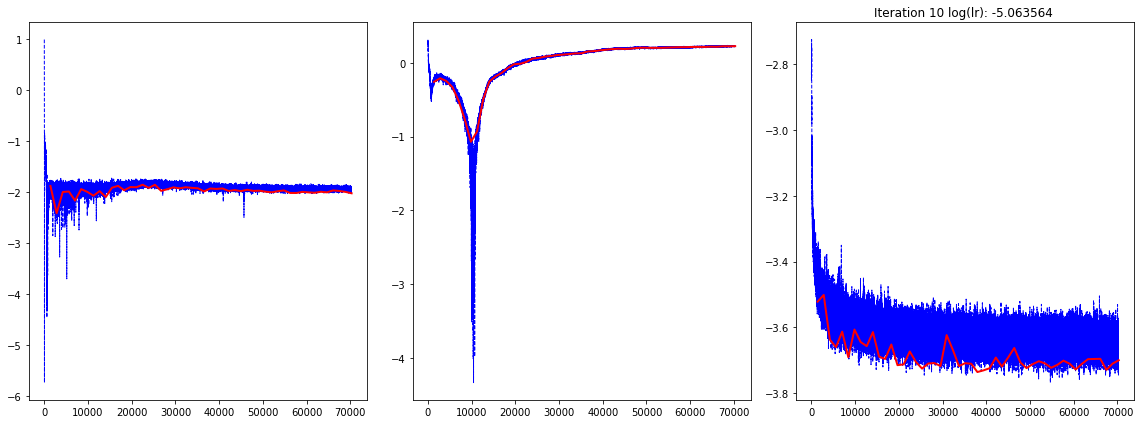

Epoch: 11-0/10 - 27(0.02) - disc_loss: -0.01183 - gen_loss: -1.68421 - vgg_loss: 1.95574  - mse_loss: 0.000238977
Epoch: 11-0/10 - 55(0.04) - disc_loss: -0.01163 - gen_loss: -1.68376 - vgg_loss: 2.01179  - mse_loss: 0.000215945
Epoch: 11-0/10 - 83(0.06) - disc_loss: -0.01043 - gen_loss: -1.67905 - vgg_loss: 1.99975  - mse_loss: 0.000197480
Epoch: 11-0/10 - 111(0.08) - disc_loss: -0.01084 - gen_loss: -1.67960 - vgg_loss: 1.89377  - mse_loss: 0.000208756
Epoch: 11-0/10 - 139(0.10) - disc_loss: -0.01117 - gen_loss: -1.67292 - vgg_loss: 1.94448  - mse_loss: 0.000219575
Epoch: 11-0/10 - 167(0.12) - disc_loss: -0.01125 - gen_loss: -1.67492 - vgg_loss: 2.00155  - mse_loss: 0.000223037
Epoch: 11-0/10 - 195(0.14) - disc_loss: -0.01122 - gen_loss: -1.70064 - vgg_loss: 1.79911  - mse_loss: 0.000217786
Epoch: 11-0/10 - 223(0.16) - disc_loss: -0.01157 - gen_loss: -1.69158 - vgg_loss: 1.89444  - mse_loss: 0.000217085
Epoch: 11-0/10 - 251(0.18) - disc_loss: -0.01212 - gen_loss: -1.68538 - vgg_loss: 2

Epoch: 11-1/10 - 615(0.44) - disc_loss: -0.01182 - gen_loss: -1.68551 - vgg_loss: 2.00009  - mse_loss: 0.000213535
Epoch: 11-1/10 - 643(0.46) - disc_loss: -0.01152 - gen_loss: -1.67104 - vgg_loss: 2.09070  - mse_loss: 0.000205967
Epoch: 11-1/10 - 671(0.48) - disc_loss: -0.01232 - gen_loss: -1.67567 - vgg_loss: 2.11493  - mse_loss: 0.000238152
Epoch: 11-1/10 - 699(0.50) - disc_loss: -0.01153 - gen_loss: -1.68328 - vgg_loss: 1.96995  - mse_loss: 0.000217906
Epoch: 11-1/10 - 727(0.52) - disc_loss: -0.01268 - gen_loss: -1.67873 - vgg_loss: 2.04173  - mse_loss: 0.000253169
Epoch: 11-1/10 - 755(0.54) - disc_loss: -0.01281 - gen_loss: -1.69529 - vgg_loss: 1.96487  - mse_loss: 0.000233633
Epoch: 11-1/10 - 783(0.56) - disc_loss: -0.01273 - gen_loss: -1.67443 - vgg_loss: 2.16475  - mse_loss: 0.000252655
Epoch: 11-1/10 - 811(0.58) - disc_loss: -0.01239 - gen_loss: -1.67493 - vgg_loss: 2.03022  - mse_loss: 0.000259531
Epoch: 11-1/10 - 839(0.60) - disc_loss: -0.01107 - gen_loss: -1.67756 - vgg_loss

Epoch: 11-2/10 - 1203(0.86) - disc_loss: -0.01142 - gen_loss: -1.68640 - vgg_loss: 2.05945  - mse_loss: 0.000234242
Epoch: 11-2/10 - 1231(0.88) - disc_loss: -0.01123 - gen_loss: -1.67992 - vgg_loss: 2.09879  - mse_loss: 0.000250835
Epoch: 11-2/10 - 1259(0.90) - disc_loss: -0.01102 - gen_loss: -1.69191 - vgg_loss: 2.02496  - mse_loss: 0.000207843
Epoch: 11-2/10 - 1287(0.92) - disc_loss: -0.01363 - gen_loss: -1.69703 - vgg_loss: 2.09605  - mse_loss: 0.000268205
Epoch: 11-2/10 - 1315(0.94) - disc_loss: -0.01065 - gen_loss: -1.69154 - vgg_loss: 1.92251  - mse_loss: 0.000218302
Epoch: 11-2/10 - 1343(0.96) - disc_loss: -0.01167 - gen_loss: -1.69441 - vgg_loss: 1.98511  - mse_loss: 0.000246782
Epoch: 11-2/10 - 1371(0.98) - disc_loss: -0.01116 - gen_loss: -1.67467 - vgg_loss: 2.14687  - mse_loss: 0.000234048
Epoch: 11-2/10 - 1399(1.00) - disc_loss: -0.01132 - gen_loss: -1.68883 - vgg_loss: 2.02138  - mse_loss: 0.000248001
Test....Epoch: 11-2/10 - disc_loss: -0.00980 - gen_loss: -1.70114 - vgg_

Epoch: 11-4/10 - 363(0.26) - disc_loss: -0.01115 - gen_loss: -1.72066 - vgg_loss: 1.77899  - mse_loss: 0.000220483
Epoch: 11-4/10 - 391(0.28) - disc_loss: -0.01169 - gen_loss: -1.70858 - vgg_loss: 2.04153  - mse_loss: 0.000254803
Epoch: 11-4/10 - 419(0.30) - disc_loss: -0.01004 - gen_loss: -1.73460 - vgg_loss: 1.71220  - mse_loss: 0.000191200
Epoch: 11-4/10 - 447(0.32) - disc_loss: -0.01115 - gen_loss: -1.72469 - vgg_loss: 1.75488  - mse_loss: 0.000211914
Epoch: 11-4/10 - 475(0.34) - disc_loss: -0.01142 - gen_loss: -1.65485 - vgg_loss: 2.40154  - mse_loss: 0.000242993
Epoch: 11-4/10 - 503(0.36) - disc_loss: -0.01086 - gen_loss: -1.70266 - vgg_loss: 1.95136  - mse_loss: 0.000245392
Epoch: 11-4/10 - 531(0.38) - disc_loss: -0.01071 - gen_loss: -1.71060 - vgg_loss: 1.92084  - mse_loss: 0.000215760
Epoch: 11-4/10 - 559(0.40) - disc_loss: -0.01167 - gen_loss: -1.70196 - vgg_loss: 1.98353  - mse_loss: 0.000227107
Epoch: 11-4/10 - 587(0.42) - disc_loss: -0.01039 - gen_loss: -1.69176 - vgg_loss

<Figure size 432x288 with 0 Axes>

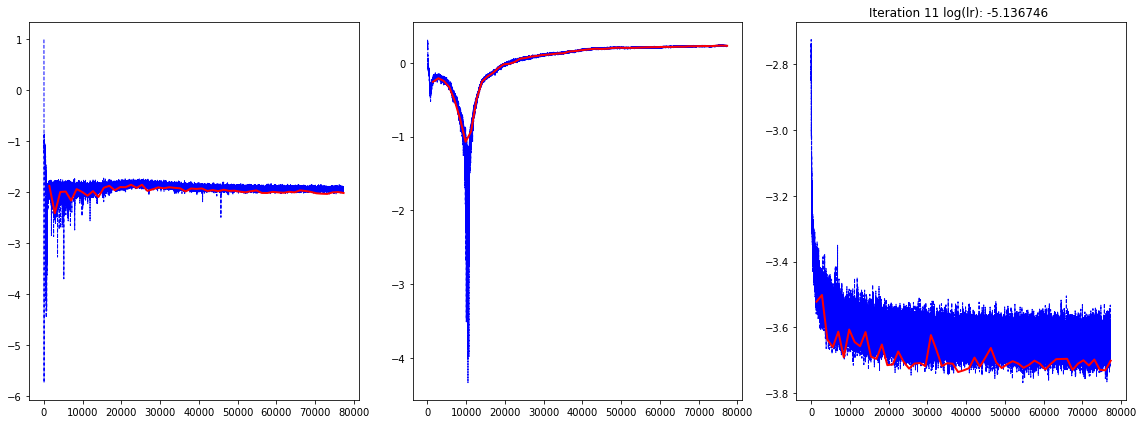

Epoch: 12-0/10 - 27(0.02) - disc_loss: -0.01031 - gen_loss: -1.72376 - vgg_loss: 1.73237  - mse_loss: 0.000216915
Epoch: 12-0/10 - 55(0.04) - disc_loss: -0.01101 - gen_loss: -1.68768 - vgg_loss: 2.07600  - mse_loss: 0.000229890
Epoch: 12-0/10 - 83(0.06) - disc_loss: -0.01049 - gen_loss: -1.72333 - vgg_loss: 1.67932  - mse_loss: 0.000221732
Epoch: 12-0/10 - 111(0.08) - disc_loss: -0.01243 - gen_loss: -1.68657 - vgg_loss: 2.16010  - mse_loss: 0.000222684
Epoch: 12-0/10 - 139(0.10) - disc_loss: -0.01231 - gen_loss: -1.70599 - vgg_loss: 2.02258  - mse_loss: 0.000242676
Epoch: 12-0/10 - 167(0.12) - disc_loss: -0.01159 - gen_loss: -1.69606 - vgg_loss: 2.07021  - mse_loss: 0.000233642
Epoch: 12-0/10 - 195(0.14) - disc_loss: -0.01129 - gen_loss: -1.72307 - vgg_loss: 1.79194  - mse_loss: 0.000224294
Epoch: 12-0/10 - 223(0.16) - disc_loss: -0.01227 - gen_loss: -1.70727 - vgg_loss: 1.95939  - mse_loss: 0.000244330
Epoch: 12-0/10 - 251(0.18) - disc_loss: -0.00997 - gen_loss: -1.68388 - vgg_loss: 2

Epoch: 12-1/10 - 615(0.44) - disc_loss: -0.01166 - gen_loss: -1.70806 - vgg_loss: 1.86269  - mse_loss: 0.000227871
Epoch: 12-1/10 - 643(0.46) - disc_loss: -0.01161 - gen_loss: -1.70800 - vgg_loss: 1.93414  - mse_loss: 0.000222879
Epoch: 12-1/10 - 671(0.48) - disc_loss: -0.01059 - gen_loss: -1.72153 - vgg_loss: 1.78894  - mse_loss: 0.000208856
Epoch: 12-1/10 - 699(0.50) - disc_loss: -0.01165 - gen_loss: -1.69837 - vgg_loss: 2.03157  - mse_loss: 0.000222393
Epoch: 12-1/10 - 727(0.52) - disc_loss: -0.01242 - gen_loss: -1.70285 - vgg_loss: 1.97978  - mse_loss: 0.000238673
Epoch: 12-1/10 - 755(0.54) - disc_loss: -0.01163 - gen_loss: -1.69797 - vgg_loss: 1.99269  - mse_loss: 0.000230325
Epoch: 12-1/10 - 783(0.56) - disc_loss: -0.01145 - gen_loss: -1.71163 - vgg_loss: 1.80910  - mse_loss: 0.000237032
Epoch: 12-1/10 - 811(0.58) - disc_loss: -0.01108 - gen_loss: -1.72211 - vgg_loss: 1.75603  - mse_loss: 0.000215033
Epoch: 12-1/10 - 839(0.60) - disc_loss: -0.01171 - gen_loss: -1.68915 - vgg_loss

Epoch: 12-2/10 - 1203(0.86) - disc_loss: -0.01182 - gen_loss: -1.69757 - vgg_loss: 1.99160  - mse_loss: 0.000214370
Epoch: 12-2/10 - 1231(0.88) - disc_loss: -0.01090 - gen_loss: -1.70905 - vgg_loss: 1.87698  - mse_loss: 0.000219819
Epoch: 12-2/10 - 1259(0.90) - disc_loss: -0.01149 - gen_loss: -1.69855 - vgg_loss: 1.94123  - mse_loss: 0.000222024
Epoch: 12-2/10 - 1287(0.92) - disc_loss: -0.01152 - gen_loss: -1.66981 - vgg_loss: 2.19010  - mse_loss: 0.000229335
Epoch: 12-2/10 - 1315(0.94) - disc_loss: -0.01064 - gen_loss: -1.70953 - vgg_loss: 1.81316  - mse_loss: 0.000214241
Epoch: 12-2/10 - 1343(0.96) - disc_loss: -0.01123 - gen_loss: -1.69786 - vgg_loss: 1.90181  - mse_loss: 0.000234660
Epoch: 12-2/10 - 1371(0.98) - disc_loss: -0.01161 - gen_loss: -1.70409 - vgg_loss: 1.85434  - mse_loss: 0.000254552
Epoch: 12-2/10 - 1399(1.00) - disc_loss: -0.01077 - gen_loss: -1.69421 - vgg_loss: 1.91093  - mse_loss: 0.000223385
Test....Epoch: 12-2/10 - disc_loss: -0.00998 - gen_loss: -1.69437 - vgg_

Epoch: 12-4/10 - 363(0.26) - disc_loss: -0.01110 - gen_loss: -1.74261 - vgg_loss: 1.86302  - mse_loss: 0.000217002
Epoch: 12-4/10 - 391(0.28) - disc_loss: -0.01083 - gen_loss: -1.73658 - vgg_loss: 1.85098  - mse_loss: 0.000227473
Epoch: 12-4/10 - 419(0.30) - disc_loss: -0.01160 - gen_loss: -1.71336 - vgg_loss: 2.17291  - mse_loss: 0.000231413
Epoch: 12-4/10 - 447(0.32) - disc_loss: -0.01141 - gen_loss: -1.73281 - vgg_loss: 1.93496  - mse_loss: 0.000205852
Epoch: 12-4/10 - 475(0.34) - disc_loss: -0.01096 - gen_loss: -1.73457 - vgg_loss: 1.92230  - mse_loss: 0.000212355
Epoch: 12-4/10 - 503(0.36) - disc_loss: -0.01046 - gen_loss: -1.73536 - vgg_loss: 1.91839  - mse_loss: 0.000222672
Epoch: 12-4/10 - 531(0.38) - disc_loss: -0.01134 - gen_loss: -1.73537 - vgg_loss: 2.01430  - mse_loss: 0.000225182
Epoch: 12-4/10 - 559(0.40) - disc_loss: -0.01099 - gen_loss: -1.75484 - vgg_loss: 1.80700  - mse_loss: 0.000225063
Epoch: 12-4/10 - 587(0.42) - disc_loss: -0.01120 - gen_loss: -1.75321 - vgg_loss

<Figure size 432x288 with 0 Axes>

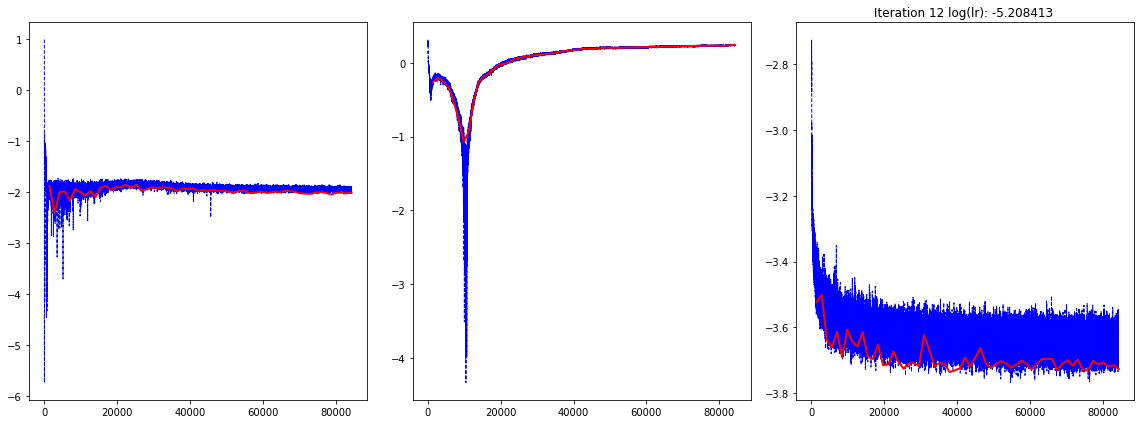

Epoch: 13-0/10 - 27(0.02) - disc_loss: -0.01109 - gen_loss: -1.74188 - vgg_loss: 1.98617  - mse_loss: 0.000206353
Epoch: 13-0/10 - 55(0.04) - disc_loss: -0.01136 - gen_loss: -1.75235 - vgg_loss: 1.95061  - mse_loss: 0.000217287
Epoch: 13-0/10 - 83(0.06) - disc_loss: -0.01108 - gen_loss: -1.75892 - vgg_loss: 1.81343  - mse_loss: 0.000214496
Epoch: 13-0/10 - 111(0.08) - disc_loss: -0.01087 - gen_loss: -1.74945 - vgg_loss: 1.85203  - mse_loss: 0.000207922
Epoch: 13-0/10 - 139(0.10) - disc_loss: -0.01148 - gen_loss: -1.74193 - vgg_loss: 1.91125  - mse_loss: 0.000214183
Epoch: 13-0/10 - 167(0.12) - disc_loss: -0.01124 - gen_loss: -1.75679 - vgg_loss: 1.81263  - mse_loss: 0.000229429
Epoch: 13-0/10 - 195(0.14) - disc_loss: -0.01048 - gen_loss: -1.74341 - vgg_loss: 1.89064  - mse_loss: 0.000199324
Epoch: 13-0/10 - 223(0.16) - disc_loss: -0.01105 - gen_loss: -1.72778 - vgg_loss: 2.14360  - mse_loss: 0.000236325
Epoch: 13-0/10 - 251(0.18) - disc_loss: -0.01176 - gen_loss: -1.73805 - vgg_loss: 2

Epoch: 13-1/10 - 615(0.44) - disc_loss: -0.01165 - gen_loss: -1.73730 - vgg_loss: 2.19195  - mse_loss: 0.000237284
Epoch: 13-1/10 - 643(0.46) - disc_loss: -0.01058 - gen_loss: -1.76903 - vgg_loss: 1.80569  - mse_loss: 0.000198823
Epoch: 13-1/10 - 671(0.48) - disc_loss: -0.01138 - gen_loss: -1.77444 - vgg_loss: 1.76926  - mse_loss: 0.000206260
Epoch: 13-1/10 - 699(0.50) - disc_loss: -0.01037 - gen_loss: -1.76171 - vgg_loss: 1.86534  - mse_loss: 0.000242109
Epoch: 13-1/10 - 727(0.52) - disc_loss: -0.01054 - gen_loss: -1.77408 - vgg_loss: 1.83839  - mse_loss: 0.000220168
Epoch: 13-1/10 - 755(0.54) - disc_loss: -0.01225 - gen_loss: -1.76071 - vgg_loss: 1.97488  - mse_loss: 0.000244914
Epoch: 13-1/10 - 783(0.56) - disc_loss: -0.01215 - gen_loss: -1.74979 - vgg_loss: 2.08929  - mse_loss: 0.000241430
Epoch: 13-1/10 - 811(0.58) - disc_loss: -0.01064 - gen_loss: -1.75013 - vgg_loss: 2.09500  - mse_loss: 0.000228439
Epoch: 13-1/10 - 839(0.60) - disc_loss: -0.01103 - gen_loss: -1.75998 - vgg_loss

Epoch: 13-2/10 - 1203(0.86) - disc_loss: -0.01112 - gen_loss: -1.76284 - vgg_loss: 2.09242  - mse_loss: 0.000249658
Epoch: 13-2/10 - 1231(0.88) - disc_loss: -0.01079 - gen_loss: -1.78905 - vgg_loss: 1.78821  - mse_loss: 0.000224637
Epoch: 13-2/10 - 1259(0.90) - disc_loss: -0.01056 - gen_loss: -1.78679 - vgg_loss: 1.72930  - mse_loss: 0.000216789
Epoch: 13-2/10 - 1287(0.92) - disc_loss: -0.01136 - gen_loss: -1.76291 - vgg_loss: 2.08663  - mse_loss: 0.000259143
Epoch: 13-2/10 - 1315(0.94) - disc_loss: -0.01164 - gen_loss: -1.77256 - vgg_loss: 2.01917  - mse_loss: 0.000228426
Epoch: 13-2/10 - 1343(0.96) - disc_loss: -0.01114 - gen_loss: -1.77678 - vgg_loss: 1.95954  - mse_loss: 0.000229407
Epoch: 13-2/10 - 1371(0.98) - disc_loss: -0.01010 - gen_loss: -1.80052 - vgg_loss: 1.74825  - mse_loss: 0.000201243
Epoch: 13-2/10 - 1399(1.00) - disc_loss: -0.01142 - gen_loss: -1.78875 - vgg_loss: 1.84180  - mse_loss: 0.000230617
Test....Epoch: 13-2/10 - disc_loss: -0.00984 - gen_loss: -1.78338 - vgg_

Epoch: 13-4/10 - 363(0.26) - disc_loss: -0.01147 - gen_loss: -1.79242 - vgg_loss: 2.01797  - mse_loss: 0.000217579
Epoch: 13-4/10 - 391(0.28) - disc_loss: -0.01083 - gen_loss: -1.79625 - vgg_loss: 1.94691  - mse_loss: 0.000212771
Epoch: 13-4/10 - 419(0.30) - disc_loss: -0.01086 - gen_loss: -1.79167 - vgg_loss: 1.96416  - mse_loss: 0.000224996
Epoch: 13-4/10 - 447(0.32) - disc_loss: -0.01122 - gen_loss: -1.77475 - vgg_loss: 2.15687  - mse_loss: 0.000230490
Epoch: 13-4/10 - 475(0.34) - disc_loss: -0.01045 - gen_loss: -1.80984 - vgg_loss: 1.79439  - mse_loss: 0.000220473
Epoch: 13-4/10 - 503(0.36) - disc_loss: -0.01057 - gen_loss: -1.80795 - vgg_loss: 1.89094  - mse_loss: 0.000225442
Epoch: 13-4/10 - 531(0.38) - disc_loss: -0.01144 - gen_loss: -1.79239 - vgg_loss: 2.02744  - mse_loss: 0.000265057
Epoch: 13-4/10 - 559(0.40) - disc_loss: -0.01040 - gen_loss: -1.81650 - vgg_loss: 1.73521  - mse_loss: 0.000200243


In [ ]:
print ("Start training ... ")

def read_dataset(file_name):
    f = h5py.File(file_name, 'r')
    data, label = np.array(f['data']), np.array(f['label'])
    f.close()
    data = np.expand_dims(data, axis=3)
    label = np.expand_dims(label, axis=3)
    #data = np.transpose(data, (0,2,3,1))
    #label = np.transpose(label, (0,2,3,1))
    return data, label

def figPlot(trMSEdata, teMSEdata):
    f, axs=plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    for ntag in range(0, 3):    
        trLine = axs[ntag].plot(np.arange(1,len(trMSEdata[:,ntag]),1), np.log10(np.abs(trMSEdata[1:,ntag])),'b--')
        teLine = axs[ntag].plot(NtrainOp[1:], np.log10(np.abs(teMSEdata[1:,ntag])), 'r')
        plt.setp(trLine, linewidth=1.0)
        plt.setp(teLine, linewidth=2.0)
        plt.title('Iteration %d log(lr): %4f ' % (iteration,np.log10(val_lr)))    
    plt.tight_layout()
    
def img2patches(Imat, patchSize = 64):
    halfPatchSize = np.floor(patchSize/2)
    Nx = Imat.shape[1]
    Ny = Imat.shape[2]
    Nv = Imat.shape[0]
    Npatchx = np.ceil(Nx/halfPatchSize-1)
    Npatchy = np.ceil(Ny/halfPatchSize-1)
    idx = np.int16(np.round(np.linspace(0, Nx-patchSize, num=Npatchx)))
    idy = np.int16(np.round(np.linspace(0, Ny-patchSize, num=Npatchy)))
    Patches = np.zeros([np.int32(Npatchx*Npatchy*Nv),patchSize,patchSize, Imat.shape[3]])
    itag = 0
    for rowtag in idx:
        for coltag in idx:
            Patches[Nv*itag:Nv*(itag+1)] = (Imat[:, rowtag:(rowtag+patchSize),coltag:(coltag+patchSize),:])
            itag += 1
    return Patches.astype('float32')

def read_matDat(filepath, dataFileNamePattern, dataNamePattern, labelFileNamePattern, labelNamePattern, fileNum):
    dataFileName = filepath+'/'+dataFileNamePattern+str(fileNum[0])
    mat_contents = sio.loadmat(dataFileName)
    data = mat_contents[dataNamePattern]
    
    labelFileName = filepath+'/'+labelFileNamePattern+str(fileNum[0])
    mat_contents = sio.loadmat(labelFileName)
    label = mat_contents[labelNamePattern]
    
    for ntag in fileNum[1:-1]:
        dataFileName = filepath+'/'+dataFileNamePattern+str(ntag)
        mat_contents = sio.loadmat(dataFileName)
        data = np.concatenate((mat_contents[dataNamePattern], data), axis=2)
        
        labelFileName = filepath+'/'+labelFileNamePattern+str(ntag)
        mat_contents = sio.loadmat(labelFileName)
        label = np.concatenate((mat_contents[labelNamePattern], data), axis=2)
    # move slice dimension to the fist axis    
    data = np.moveaxis(data, 2, 0)
    label = np.moveaxis(label, 2, 0) 
    data = np.expand_dims(data, axis=3)
    label = np.expand_dims(label, axis=3)
    return data, label

def shuffled_dat_Read(filename, datname, lblname):
    with h5py.File(filename,'r') as fi:
        idat = np.expand_dims(np.array(fi[datname]).astype('uint8'), axis=3)
        ilbl = np.expand_dims(np.array(fi[lblname]).astype('uint8'), axis=3)
    return idat, ilbl
    

# filepath = 'G:/STED Confocla superresolution/2D obj 2D img/thin slice (z at 0)'
# tr_data, tr_label = read_matDat(filepath,'STEDimgs','GTimgs', np.arange(7,9,1))
# te_data, te_label = read_matDat(filepath,'STEDimgs','GTimgs', np.arange(11,12,1))
filepath = 'E:/Tutorial'

te_data, te_label = read_matDat(filepath,'STEDout','STEDimgs','GTout','GTimgs', np.arange(11,12,1))
te_data = img2patches(te_data)/256
te_label = img2patches(te_label)/256

trMSEdata = np.array([[0,0,0]])
teMSEdata = np.array([[0,0,0]])
NtrainOp = np.array([0])
for iteration in range(1,num_epoch):
    val_lr = learning_rate / np.sqrt(iteration + 1)*np.exp(-iteration/Eperiod)
    
    for itag in range(5):
#         tr_data, tr_label = read_matDat(filepath,'pSTEDout','STEDimgs','pGTout','GTimgs', np.arange(itag,itag+1,1))
        datfilename = 'E:/Tutorial/SR_data_Shuffled/M{}.h5'.format(itag)
        tr_data, tr_label = shuffled_dat_Read(datfilename, 'STEDimgs', 'GTimgs')
        tr_data, tr_label = shuffle(img2patches(tr_data)/256, img2patches(tr_label)/256)
        num_batches = tr_data.shape[0] // batch_size
   
        for i in range(1,num_batches):
            start_time = time.time()
        
            # update discriminator
            for j in range(1,disc_iters):
                idx = np.random.permutation(tr_data.shape[0])
                batch_data = tr_data[idx[:batch_size]]   # Batch(128) x height x width x 1
                batch_label = tr_label[idx[:batch_size]] # Batch(128) x height x width x 1
                sess.run([disc_train_op], feed_dict={real_label: normalization(batch_label),
                                                         X: normalization(batch_data),
                                                        lr: val_lr})

            batch_data = tr_data[i*batch_size : (i+1)*batch_size]
            batch_label = tr_label[i*batch_size : (i+1)*batch_size]

            # update generator
            _disc_loss, _Wass_D, _vgg_cost, _mse_cost, _gen_loss, _gen_cost, _ = sess.run(
                [disc_loss, Wass_D, vgg_cost, mse_cost, gen_loss, gen_cost, gen_train_op],
                feed_dict={real_label: normalization(batch_label), X: normalization(batch_data), lr: val_lr})
    
            t = time.time() - start_time
            if (i+1)%np.round(num_batches/50) == 0:
                print('Epoch: %d-%d/10 - %d(%.2f) - disc_loss: %.5f - gen_loss: %.5f - vgg_loss: %.5f  - mse_loss: %.9f'
                      %(iteration, itag, i, i/num_batches, _disc_loss , _gen_loss, _vgg_cost  , _mse_cost ))

            logging.info('%d, %d, %.6f, %.6f,  %.6f,  %.6f,  %.9f,  %.6f,  %.6f, 1'
                         %(iteration, i, t, _disc_loss, _Wass_D, _vgg_cost , _mse_cost , _gen_loss, _gen_cost))   
            
            trMSEdata = np.concatenate((trMSEdata, np.array([[_disc_loss,_gen_loss,_mse_cost]])), axis=0)
    
  
        # testing
        _mse_cost = 0.0
        _vgg_cost = 0.0
    

        _disc_loss = 0.0
        _Wass_D = 0.0
        _gen_loss = 0.0
        _gen_cost = 0.0

        start_time = time.time()
        test_num_batch = te_data.shape[0] // batch_size
        for j in range(1, test_num_batch):
            batch_data = te_data[j*batch_size:(j+1)*batch_size]
            batch_label = te_label[j*batch_size:(j+1)*batch_size]
            t_disc_loss, t_Wass_D, t_vgg_cost, t_mse_cost, t_gen_loss, t_gen_cost = sess.run(
                [disc_loss, Wass_D, vgg_cost, mse_cost, gen_loss, gen_cost], 
                feed_dict={real_label: normalization(batch_label), X: normalization(batch_data)})
            
            _mse_cost += t_mse_cost
            _vgg_cost += t_vgg_cost
            _disc_loss += t_disc_loss
            _Wass_D += t_Wass_D
            _gen_loss += t_gen_loss
            _gen_cost += t_gen_cost
        
        t = time.time() - start_time
    
        _mse_cost /= (test_num_batch)
        _vgg_cost /= (test_num_batch)
        _disc_loss /= (test_num_batch)
        _Wass_D /= (test_num_batch)
        _gen_loss /= (test_num_batch)
        _gen_cost /= (test_num_batch)
    
        print('Test....Epoch: %d-%d/10 - disc_loss: %.5f - gen_loss: %.5f - vgg_loss: %.5f - mse_loss: %.9f'
              %(iteration, itag, _disc_loss , _gen_loss, _vgg_cost , _mse_cost ))
        
        teMSEdata = np.concatenate((teMSEdata, np.array([[_disc_loss,_gen_loss,_mse_cost]])), axis=0)

        logging.info('%d, %d, %.6f, %.6f,  %.6f,  %.6f,  %.9f,   %.6f,  %.6f, 0'
                     %(iteration, i, t, _disc_loss, _Wass_D, _vgg_cost , _mse_cost  , _gen_loss, _gen_cost))
        saver.save(sess, Networkfolder +'/CPCE_SR-'+repr(iteration) + '.ckpt')
        NtrainOp = np.append(NtrainOp, NtrainOp[-1]+num_batches)

    if (iteration+1):
        plt.figure(1)
        figPlot(trMSEdata, teMSEdata)
        if (iteration == num_epoch-1) or ((iteration+1)%10 == 0):
            plt.savefig('./'+ Networkfolder +'/SR%d_iteration_%d.png' % (train_version,iteration))        
        plt.show()        
        plt.close()    

sess.close()

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession().close()

# input size
X = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 1])
with tf.variable_scope('generator_model') as scope:
    # Y is the output of network
    Y = CPCE(X, padding='valid') 
    
# ground truth
real_label = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 1])
mse_cost = tf.reduce_mean(tf.squared_difference(out, Y)) 

X_batch, Y_batch = read_matDat(filepath,'STEDout','STEDimgs','GTout','GTimgs', np.arange(11,12,1))
Y_batch = Y_batch.astype('float32')

with tf.Session() as sess:
    saver = tf.train.Saver()
    sess_path =Networkfolder+'/CPCE_SR-29.ckpt'
    saver.restore(sess, sess_path)
    _out,_mse_cost = sess.run([Y,mse_cost], feed_dict={X:X_batch.astype('float32'), Y:Y_batch.astype('float32')})
    
sess.close  
print('mse_cost is %.8f' % _mse_cost)

aErr = _out - Y_batch 
rErr = (_out - (Y_batch+0.001))/(Y_batch+0.001)*100
I_in =  X_batch 

tstnum = 1


plt.figure
plt.imshow(rErr[tstnum,:,:])
plt.title('rerror')
plt.colorbar()
plt.show()

plt.figure
plt.imshow(aErr[tstnum,:,:])
plt.title('abs error')
plt.colorbar()
plt.show()

plt.figure
plt.imshow(X_batch[tstnum,:,:])
plt.title('input')
plt.colorbar()
plt.show()

plt.figure
plt.imshow(_out[tstnum,:,:])
plt.title('output')
plt.colorbar()
plt.show()

plt.figure
plt.imshow(Y_batch[tstnum,:,:])
plt.title('gt')
plt.colorbar()
plt.show()

# 